In [150]:
import torch
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM
import matplotlib.pyplot as plt
import numpy as np
from enum import Enum
from collections import defaultdict
import json

### TODO: Load in datasets to see how to sparsify v for 
- One coding dataset
- One wiki dataset
- One general internet dataset
- One dialogue/assistant dataset

### TODO: Report the percentage of logits needed for cumsum to be 80, 90, 95, 99%
- if you keep the top n% for n in 1, 5, 10, 20, what are their percentages
### TODO: Run metrics across different sequence lengths
- Find max seq length and use prefixes of it
  -  also filter out sequences under a certain length
- report metrics at intermediate sequence lengths
  - ex). on __ sequences, these are the metrics for __ sequence length
- Track worst case (sparsity) - when the data is not sparse b/c all the logits are close
  - more evenly distrubuted logits


In [151]:
class DatasetTypes(Enum):
    WIKI = ('wikitext', 'wikitext-2-raw-v1')
    INTERNET = 'Skylion007/openwebtext'
    CODE = 'bigcode/starcoderdata'
    ASSISTANT = 'HuggingFaceH4/ultrachat_200k'

def get_dataset (dataset_type: DatasetTypes):
    if dataset_type == DatasetTypes.WIKI:
        return load_dataset(dataset_type.value[0], dataset_type.value[1], streaming=True)
    return load_dataset(dataset_type.value, streaming=True)


In [152]:
dataset = get_dataset(DatasetTypes.WIKI)

In [153]:
# Load tokenizer and model
model_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, output_attentions=True)

In [180]:
num_of_samples = 1

In [181]:
stream = iter(dataset['train'])

In [182]:
min_seq_len = 100
top_ks = [1, 5, 10, 20]
metric_cumsums = [80, 90, 95, 99]
samples_metrics = list()


In [198]:
# Encode input and create tensors
for i in range(num_of_samples):
    input_text = next(stream)['text']
    
    while len(input_text) < min_seq_len:
        input_text = next(stream)['text']

    print(input_text)

    inputs = tokenizer(input_text, return_tensors="pt")
    
    metrics = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: 0.0))))
    
    # Run the model
    with torch.no_grad():
        outputs = model(**inputs)

    # Get the attentions
    attentions = outputs.attentions  # Tuple of tensors: one for each layer

    # make a tril matrix of size [sequence_length, sequence_length]
    sequence_length = attentions[0].shape[-1]
    print(sequence_length)

    for h in range(len(attentions)):
        for l, layer_attention in enumerate(attentions):
            att = layer_attention[0, h, -1, :].sort().values
            reverse_att = att.flip(0)
            total_prob = att.cumsum(0)
            reverse_total_prob = reverse_att.cumsum(0)
            for k, total_sum in zip(top_ks, metric_cumsums):
                k_percentile, desired_sum = k / 100, total_sum / 100
                
                min_elements = torch.nonzero(reverse_total_prob > desired_sum)[0]

                top_percentile_prob = total_prob[-int(k_percentile * sequence_length)]

                prev_precentile = metrics[l][h]["top_percentile_prob"]
                prev_total_sum = metrics[l][h][ "min_logits_for_cumsum"]
                prev_precentile[f"{k}%"] = 1 - top_percentile_prob.item()
                prev_total_sum[f"{total_sum}%"] = 1 + min_elements.item()
    samples_metrics.append(metrics) 

 The game 's battle system , the BliTZ system , is carried over directly from Valkyira Chronicles . During missions , players select each unit using a top @-@ down perspective of the battlefield map : once a character is selected , the player moves the character around the battlefield in third @-@ person . A character can only act once per @-@ turn , but characters can be granted multiple turns at the expense of other characters ' turns . Each character has a field and distance of movement limited by their Action Gauge . Up to nine characters can be assigned to a single mission . During gameplay , characters will call out if something happens to them , such as their health points ( HP ) getting low or being knocked out by enemy attacks . Each character has specific " Potentials " , skills unique to each character . They are divided into " Personal Potential " , which are innate skills that remain unaltered unless otherwise dictated by the story and can either help or impede a character

In [184]:
print(json.dumps(samples_metrics, indent=4))

[
    {
        "0": {
            "0": {
                "top_percentile_prob": {
                    "1%": 5.960464477539063e-08,
                    "5%": 0.5643669664859772,
                    "10%": 0.6781271994113922,
                    "20%": 0.7969141751527786
                },
                "min_logits_for_cumsum": {
                    "80%": 33,
                    "90%": 62,
                    "95%": 87,
                    "99%": 128
                }
            },
            "1": {
                "top_percentile_prob": {
                    "1%": 5.960464477539063e-08,
                    "5%": 0.9884487222880125,
                    "10%": 0.9922583661973476,
                    "20%": 0.995682405307889
                },
                "min_logits_for_cumsum": {
                    "80%": 1,
                    "90%": 1,
                    "95%": 1,
                    "99%": 10
                }
            },
            "2": {
                "top_percenti

In [199]:
def worst_case_sparsity_analytics (metrics, cumsum_axis:int):
    for layer in metrics:
        min_elements = [metrics[layer][head]["min_logits_for_cumsum"][cumsum_axis] for head in metrics[layer]]
        plt.hist(min_elements, bins=max(min_elements), alpha=0.75)

        plt.title(f'Min Logits Cumulative Sum Distribution - Layer {layer}')
        plt.xlabel(f'Min Logits Needed for cumsum = {cumsum_axis}')
        plt.ylabel('Frequency')
        plt.grid(True)
        plt.show()

In [200]:
def analyze_cases(data):
    """
    Analyze the samples and return the average and worst case values for the top_percentile_prob and min_logits_for_cumsum metrics
    for each layer and head in the model.
    """
    # Initialize dictionaries to store the results
    top_percentile_prob_avg = defaultdict(lambda:defaultdict(lambda: defaultdict(lambda: 0.0)))
    top_percentile_prob_worst = defaultdict(lambda:defaultdict(lambda: defaultdict(lambda: 1.0)))
    min_logits_for_cumsum_avg = defaultdict(lambda:defaultdict(lambda: defaultdict(lambda: 0.0)))
    min_logits_for_cumsum_worst = defaultdict(lambda:defaultdict(lambda: defaultdict(lambda: 0.0)))

    # Iterate over each sample
    for sample in data:
        # Iterate over each layer in the sample
        for layer in sample:
            # Iterate over each head in the layer
            for head in sample[layer]:
                # Extract top_percentile_prob and min_logits_for_cumsum data
                top_percentile_prob_data = sample[layer][head]['top_percentile_prob']
                min_logits_for_cumsum_data = sample[layer][head]['min_logits_for_cumsum']

                # for each head, update the average and worst case values
                for key in top_percentile_prob_data:
                    top_percentile_prob_avg[layer][head][key] += top_percentile_prob_data[key]
                    top_percentile_prob_worst[layer][head][key] = min(top_percentile_prob_worst[layer][head][key], top_percentile_prob_data[key])

                for key in min_logits_for_cumsum_data:
                    min_logits_for_cumsum_avg[layer][head][key] += min_logits_for_cumsum_data[key]
                    min_logits_for_cumsum_worst[layer][head][key] = max(min_logits_for_cumsum_worst[layer][head][key], min_logits_for_cumsum_data[key])

    # Calculate the average values
    for layer in top_percentile_prob_avg:
        for head in top_percentile_prob_avg[layer]:
            for key in top_percentile_prob_avg[layer][head]:
                top_percentile_prob_avg[layer][head][key] /= len(data)
            
    return top_percentile_prob_avg, top_percentile_prob_worst, min_logits_for_cumsum_avg, min_logits_for_cumsum_worst

In [201]:
top_percentile_prob_avg, top_percentile_prob_worst, min_logits_for_cumsum_avg, min_logits_for_cumsum_worst = analyze_cases(samples_metrics)

In [203]:
print(json.dumps(top_percentile_prob_avg[0][0], indent=4))
print(json.dumps(top_percentile_prob_worst[0][0], indent=4))
print(json.dumps(min_logits_for_cumsum_avg[0][0], indent=4))
print(json.dumps(min_logits_for_cumsum_worst[0][0], indent=4))


{
    "1%": 0.1426489233970642,
    "5%": 0.5562763094902039,
    "10%": 0.6811050623655319,
    "20%": 0.8033903017640114
}
{
    "1%": -1.1920928955078125e-07,
    "5%": 0.44953101873397827,
    "10%": 0.5567584931850433,
    "20%": 0.7084000110626221
}
{
    "80%": 155.0,
    "90%": 283.0,
    "95%": 423.0,
    "99%": 693.0
}
{
    "80%": 33,
    "90%": 65,
    "95%": 112,
    "99%": 218
}


In [205]:
import matplotlib.pyplot as plt

def plot_histograms_by_key(data):
    top_percentile_prob_avg, top_percentile_prob_worst, min_logits_for_cumsum_avg, min_logits_for_cumsum_worst = analyze_cases(data)

    # Plot histograms for top_percentile_prob_avg
    for layer in top_percentile_prob_avg:
        for head in top_percentile_prob_avg[layer]:
            for key in top_percentile_prob_avg[layer][head]:
                plt.figure(figsize=(10, 5))
                plt.hist(top_percentile_prob_avg[layer][head][key], bins=20, alpha=0.5, label='Average')
                plt.hist(top_percentile_prob_worst[layer][head][key], bins=20, alpha=0.5, label='Worst')
                plt.title(f'top_percentile_prob for Layer {layer} Head {head} Key {key}')
                plt.legend()
                plt.show()

    # Plot histograms for min_logits_for_cumsum_avg
    for layer in min_logits_for_cumsum_avg:
        for head in min_logits_for_cumsum_avg[layer]:
            for key in min_logits_for_cumsum_avg[layer][head]:
                plt.figure(figsize=(10, 5))
                plt.hist(min_logits_for_cumsum_avg[layer][head][key], bins=20, alpha=0.5, label='Average')
                plt.hist(min_logits_for_cumsum_worst[layer][head][key], bins=20, alpha=0.5, label='Worst')
                plt.title(f'min_logits_for_cumsum for Layer {layer} Head {head} Key {key}')
                plt.legend()
                plt.show()

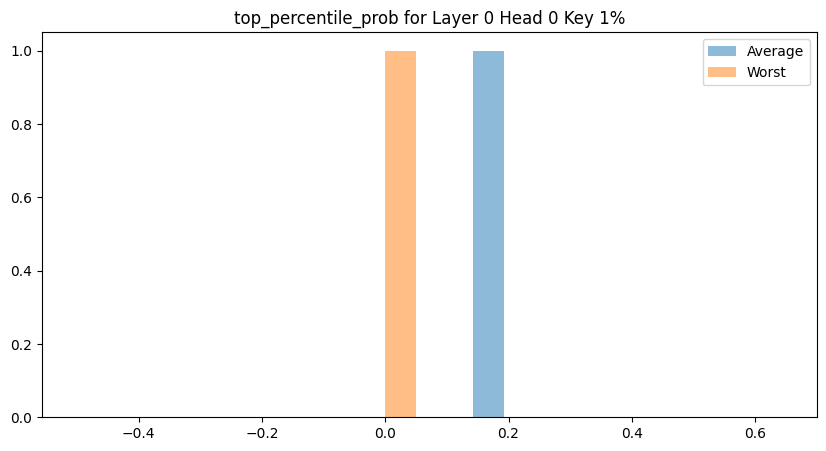

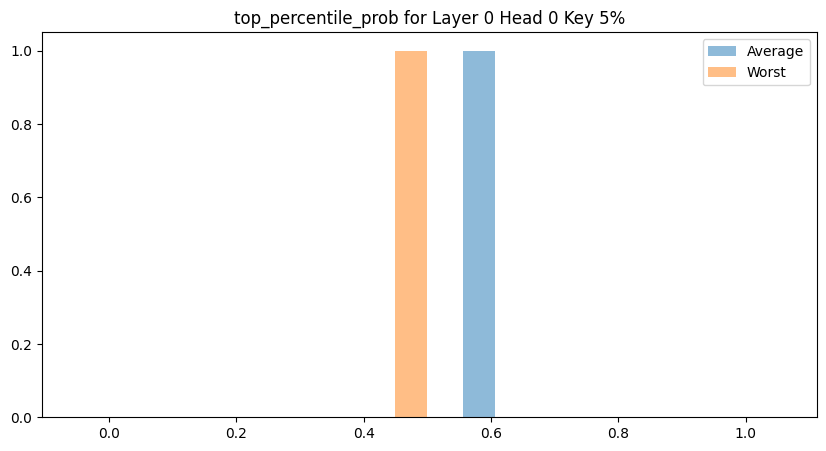

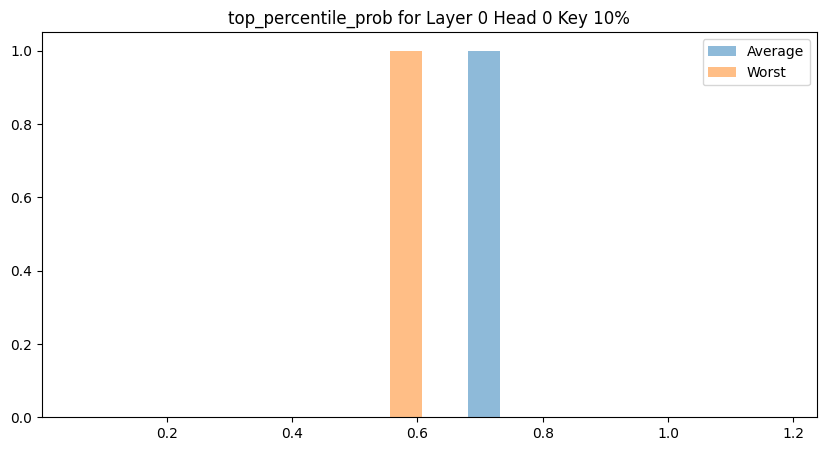

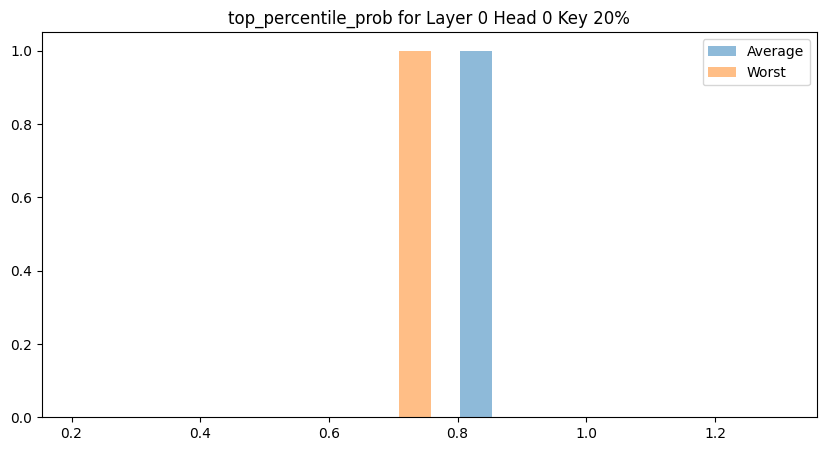

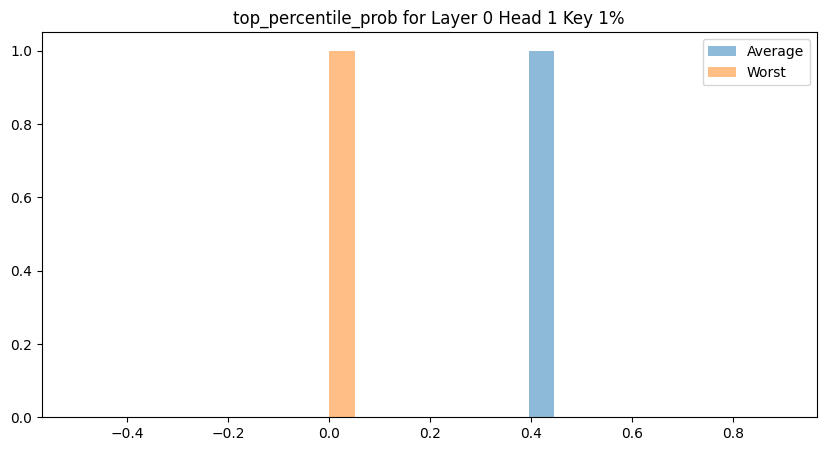

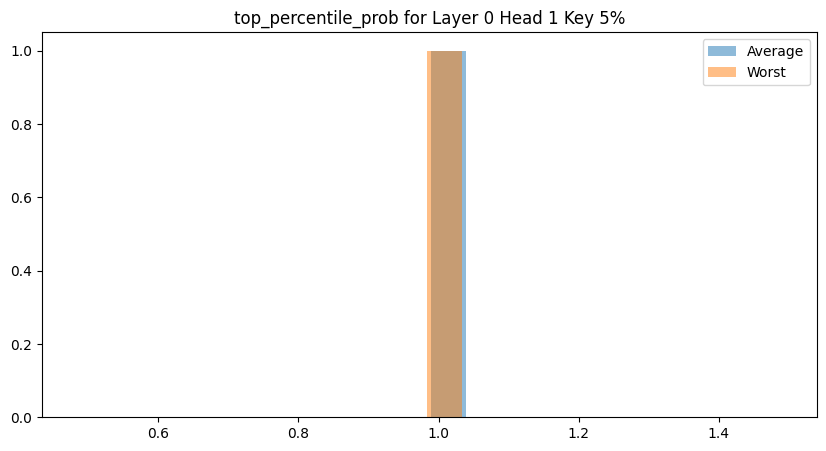

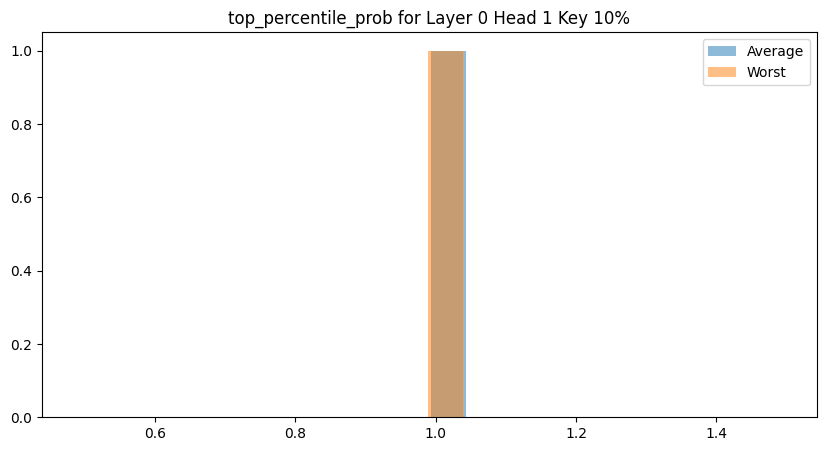

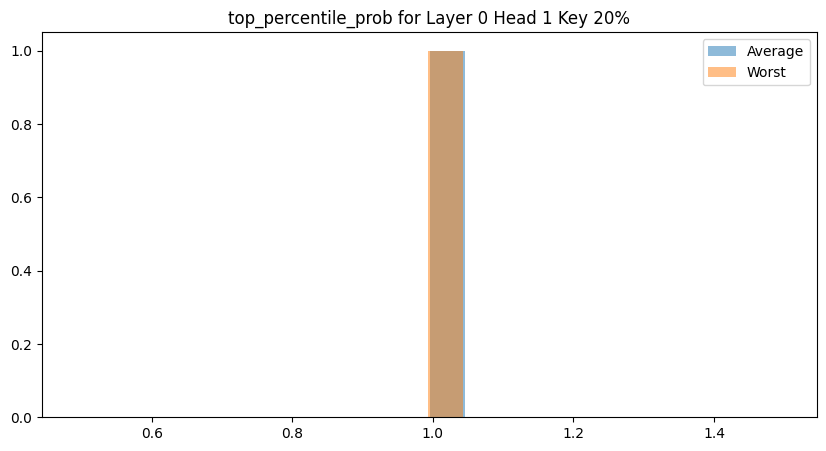

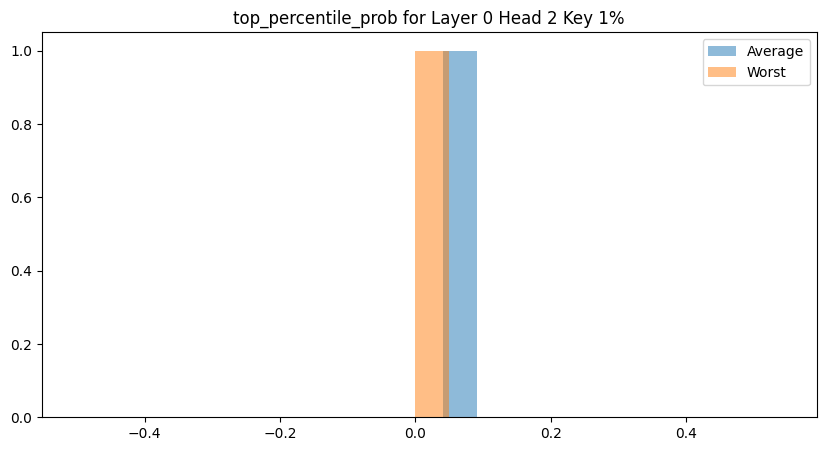

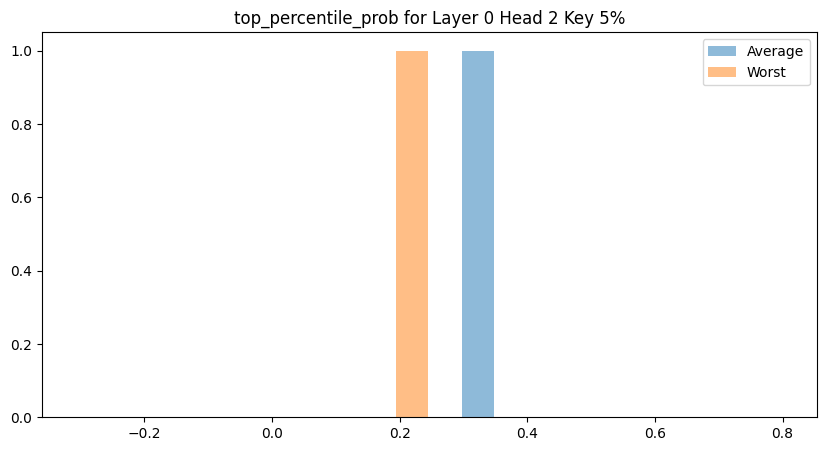

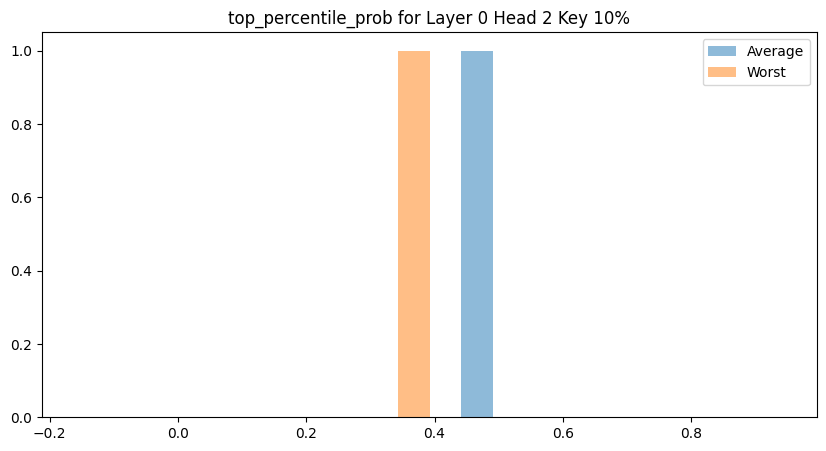

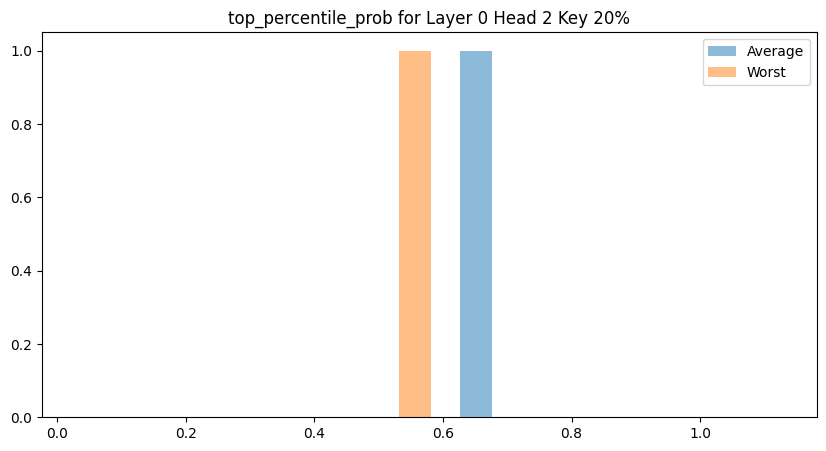

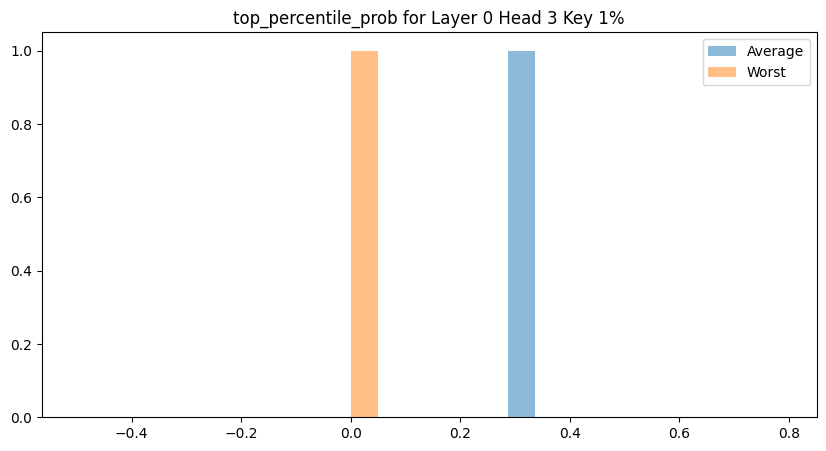

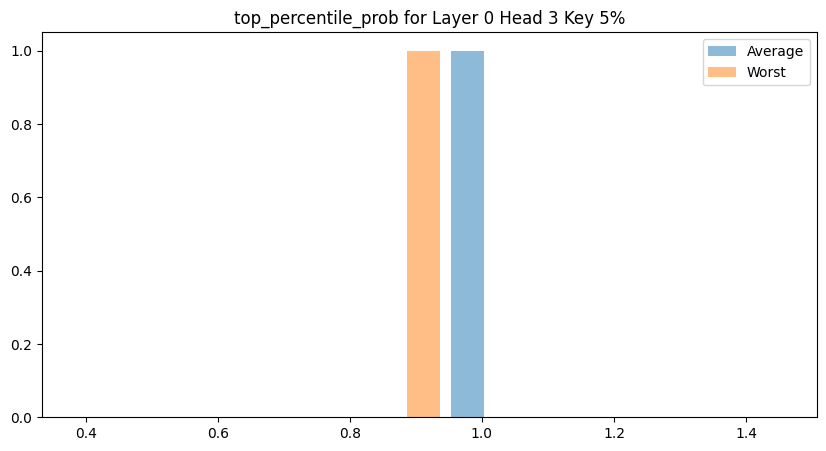

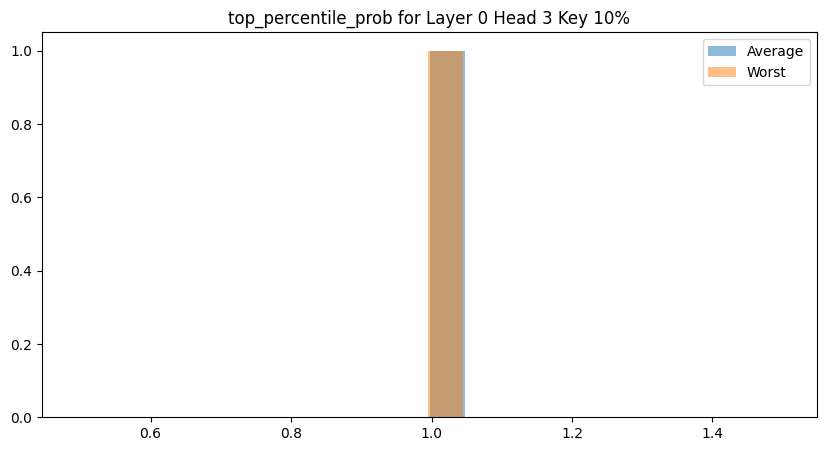

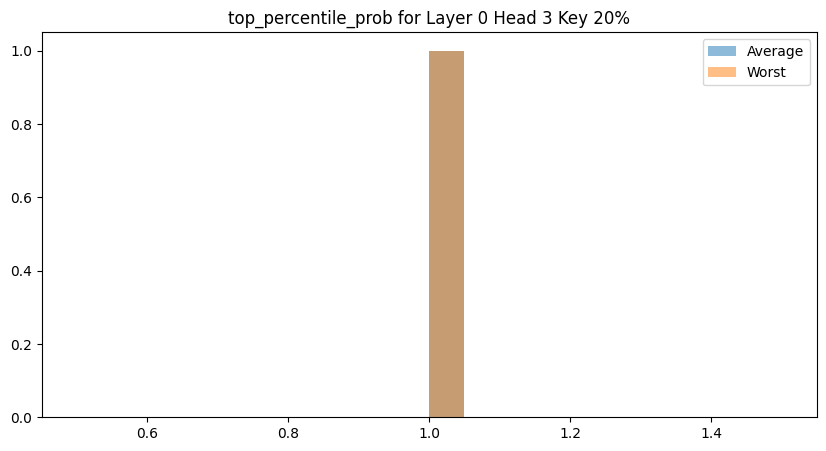

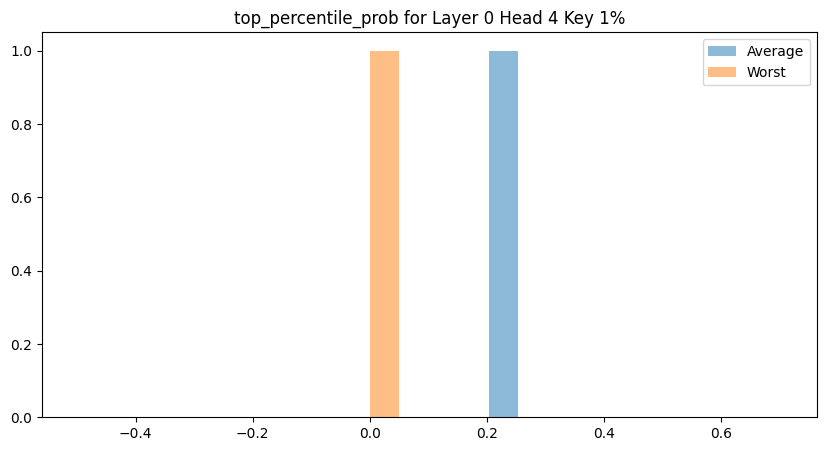

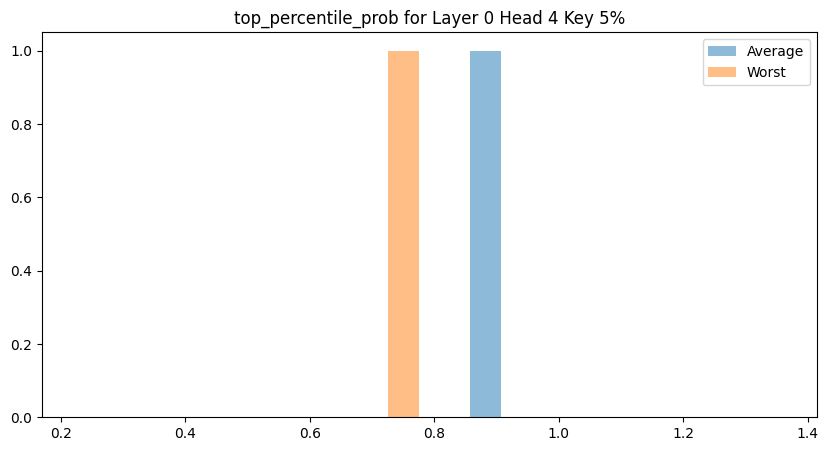

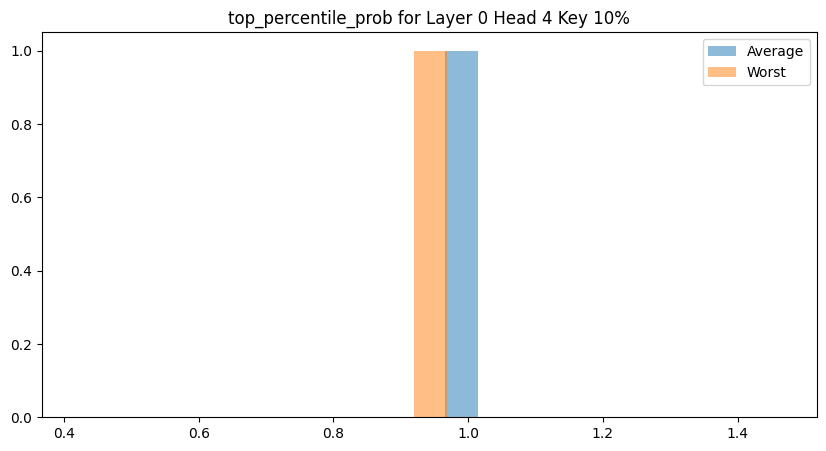

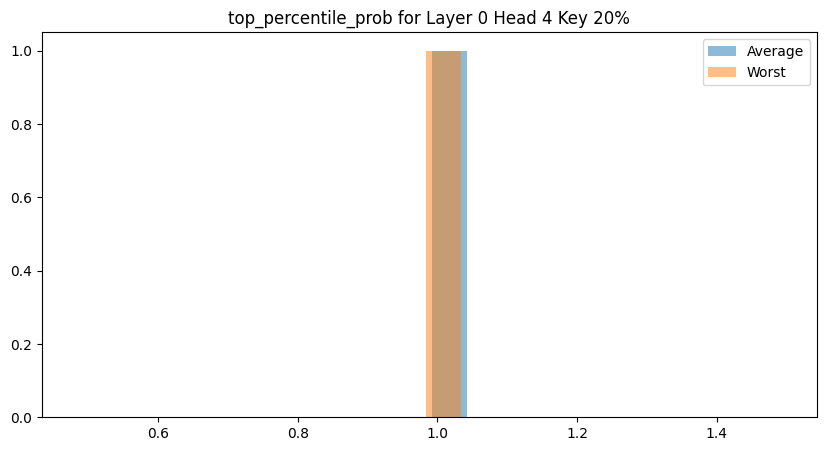

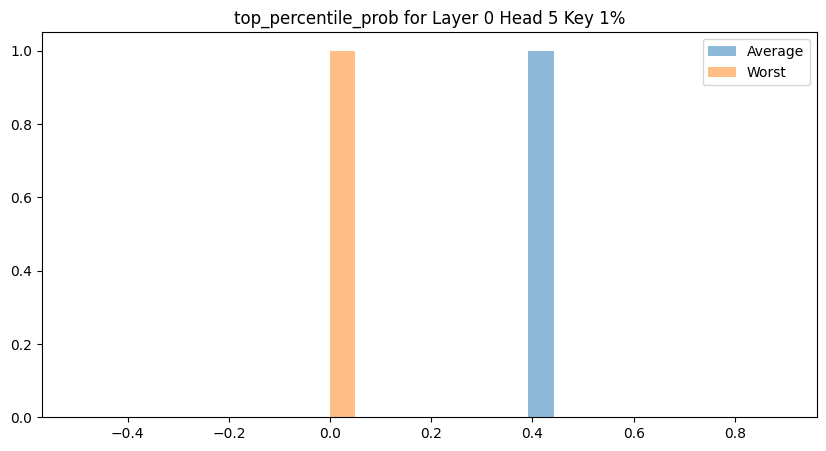

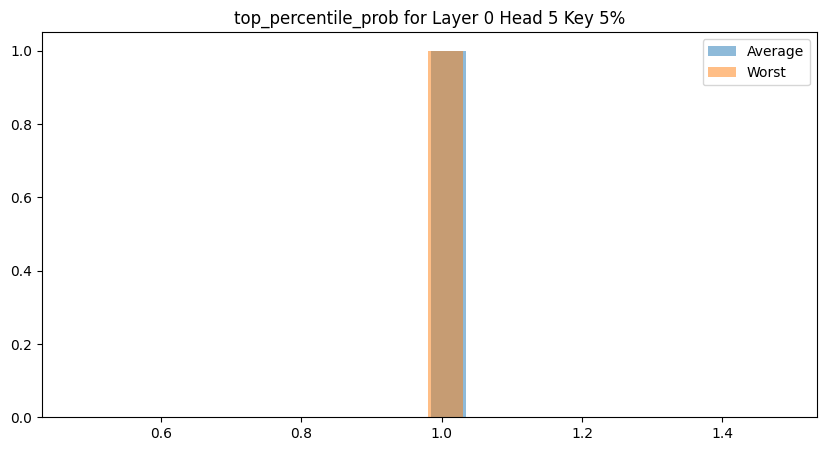

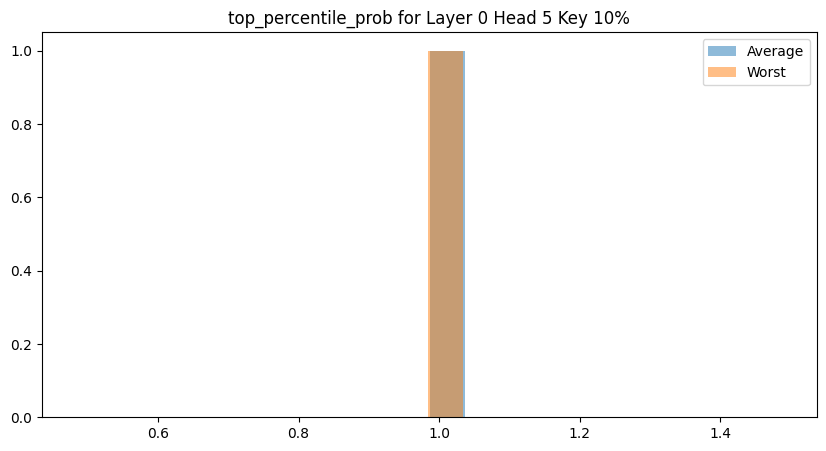

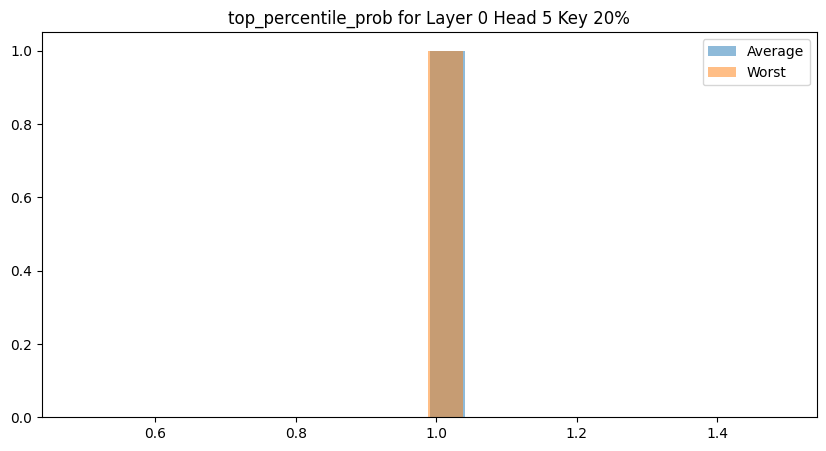

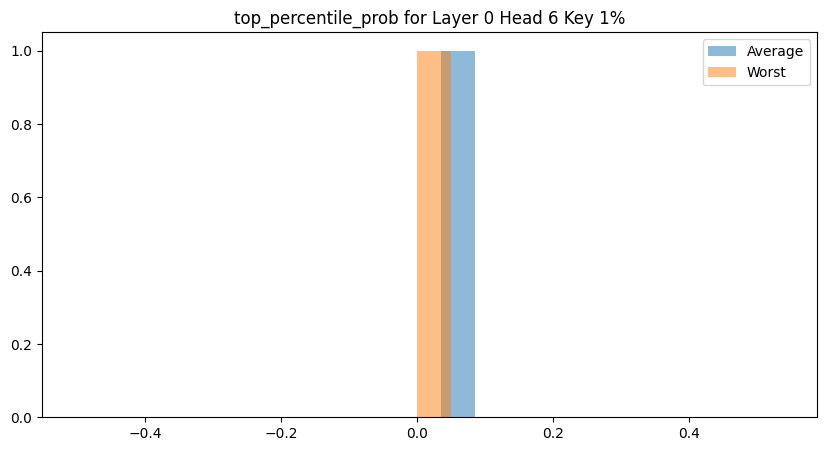

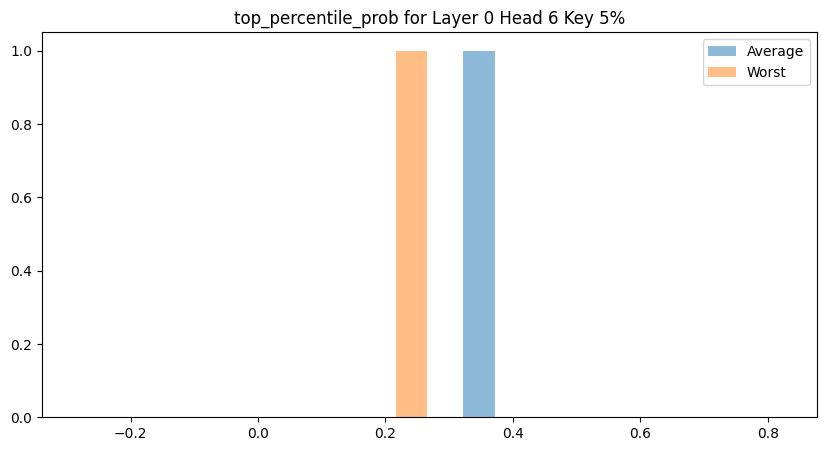

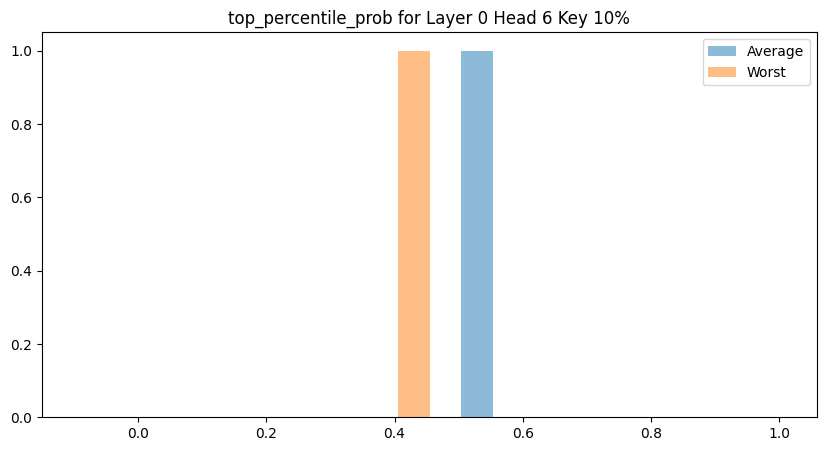

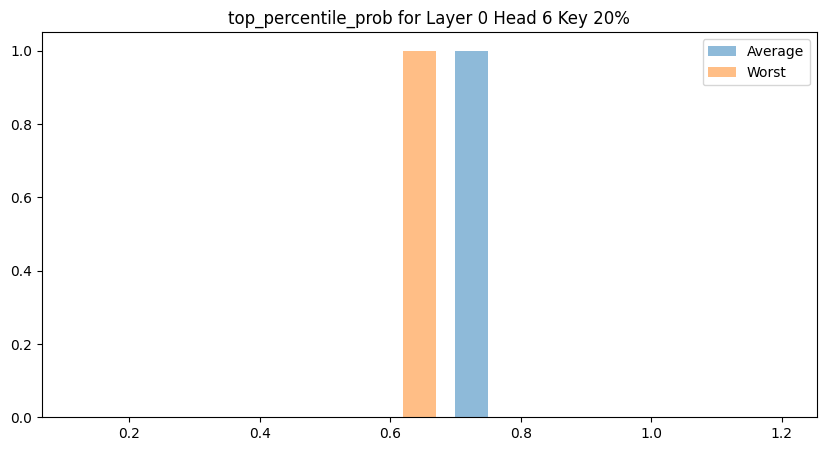

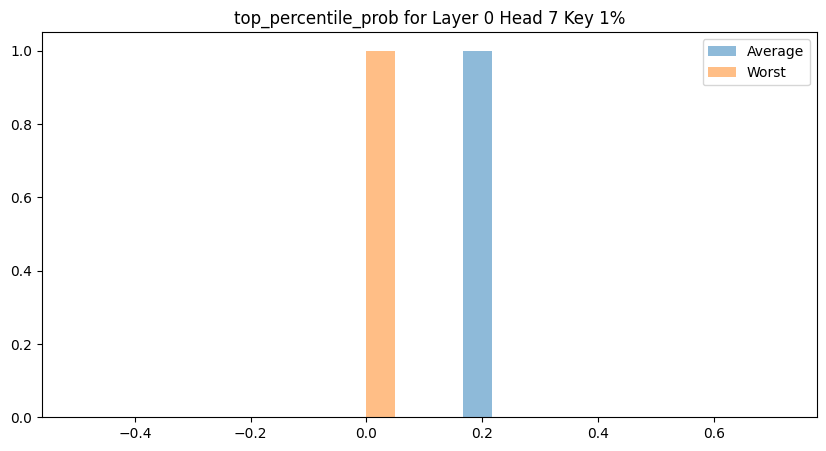

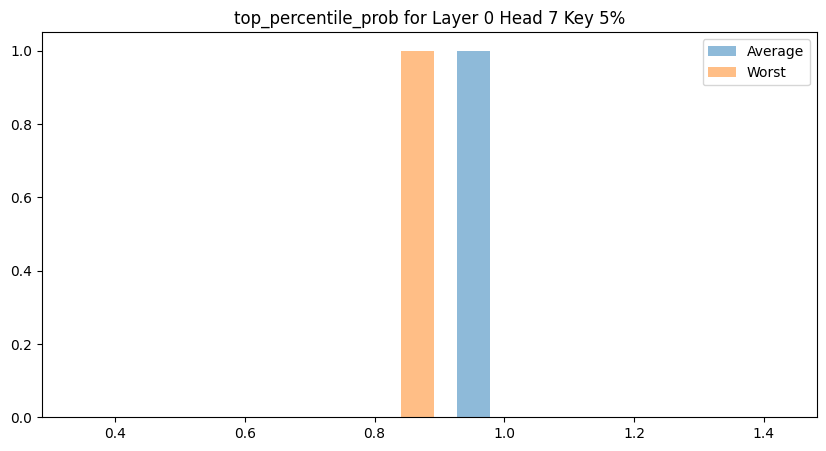

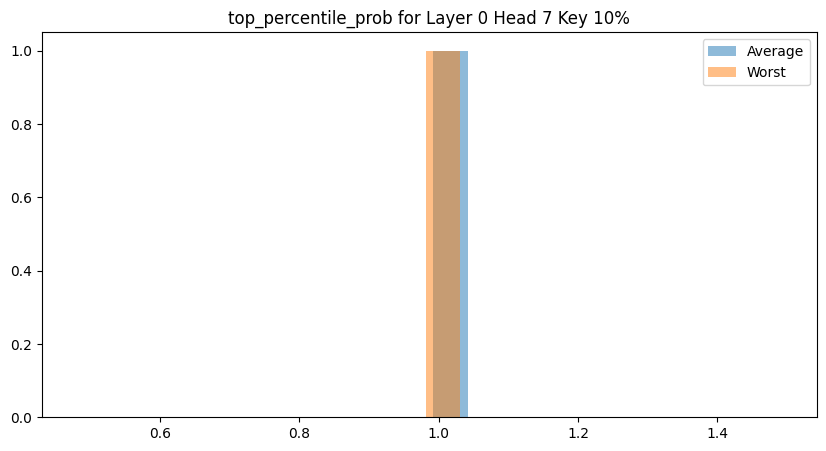

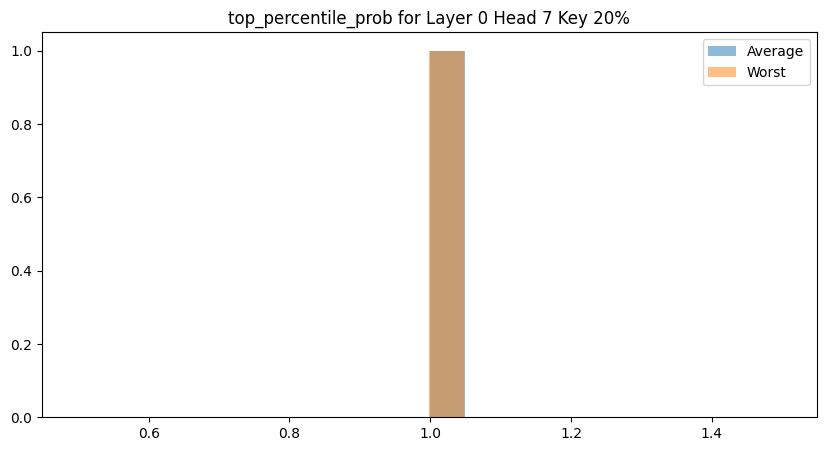

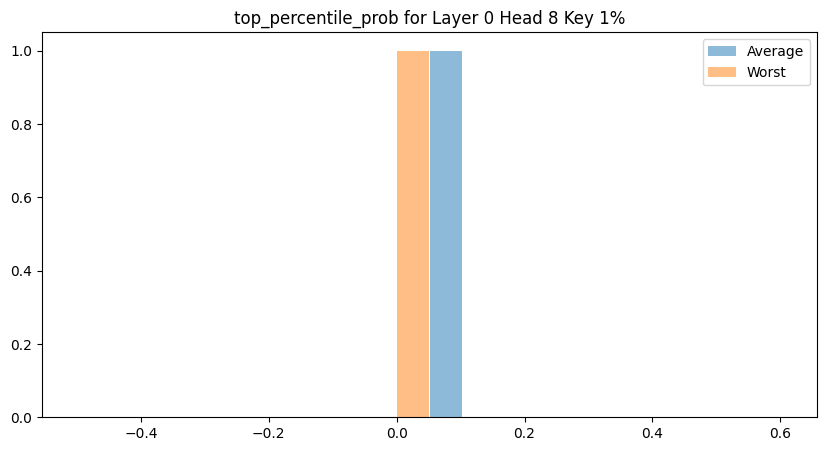

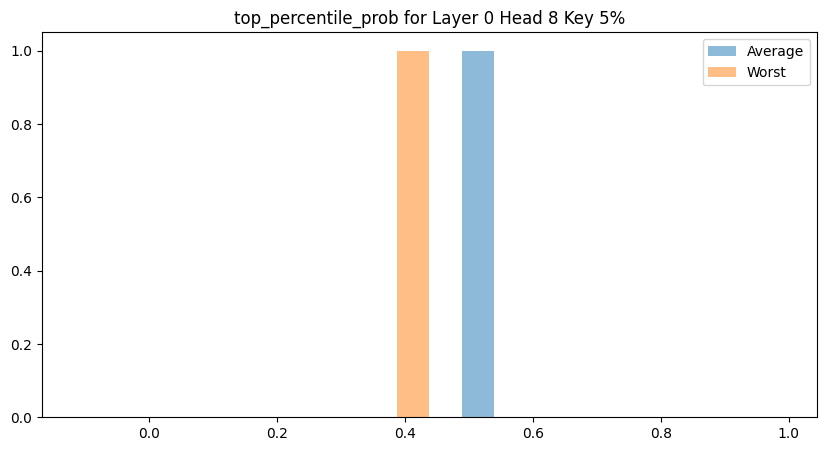

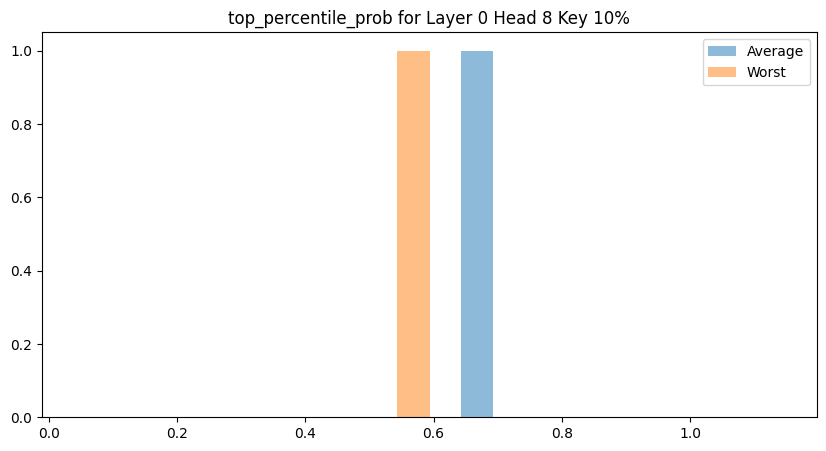

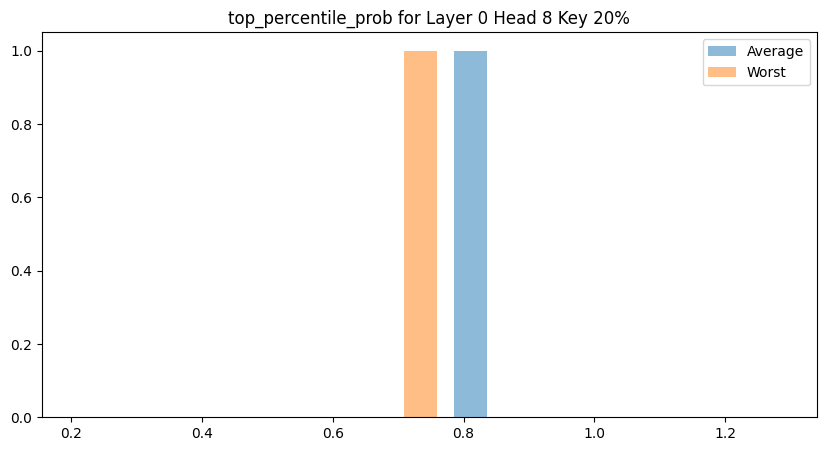

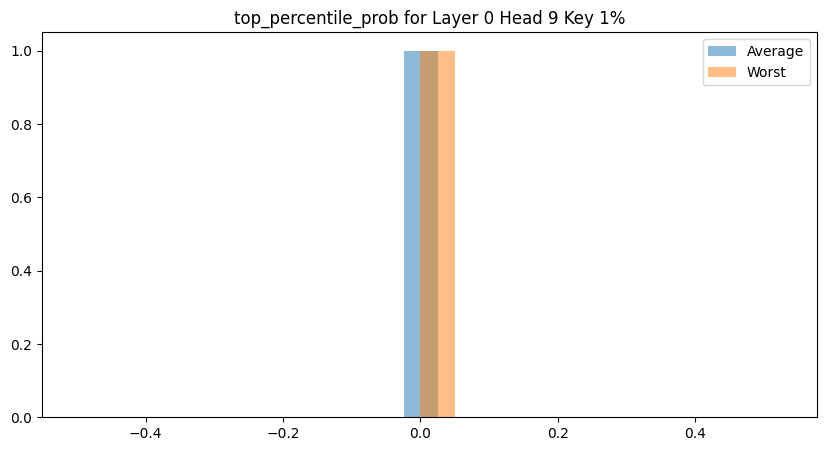

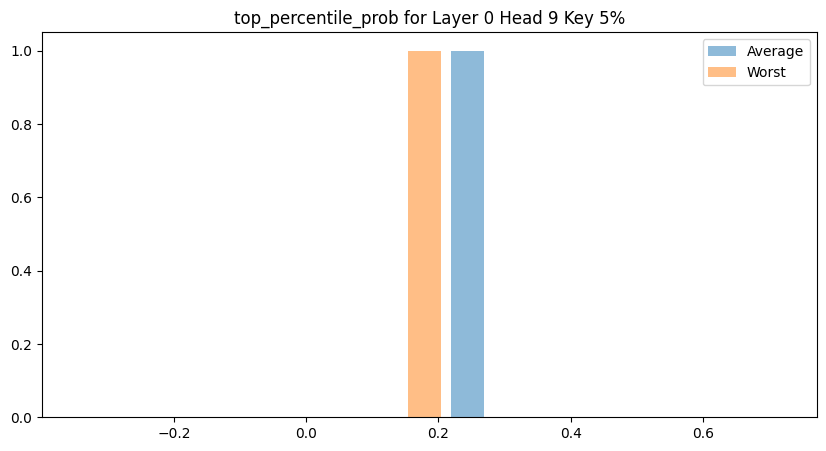

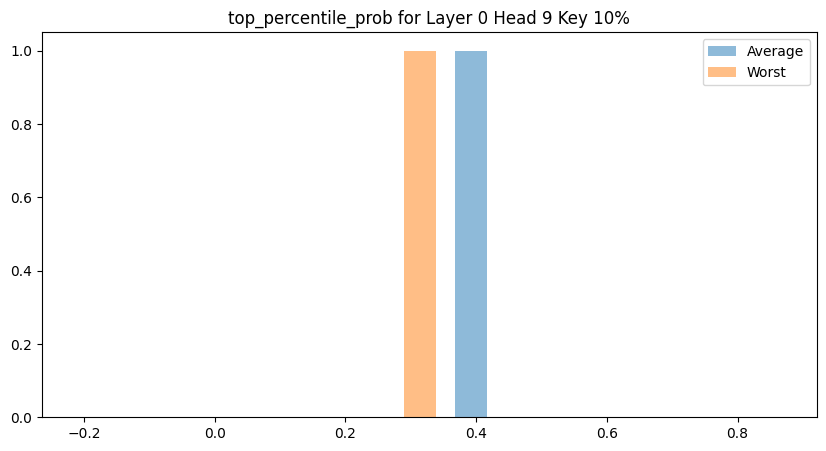

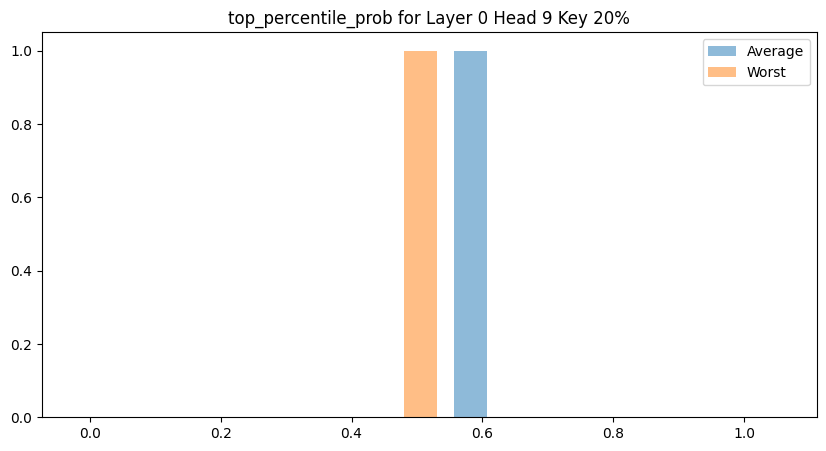

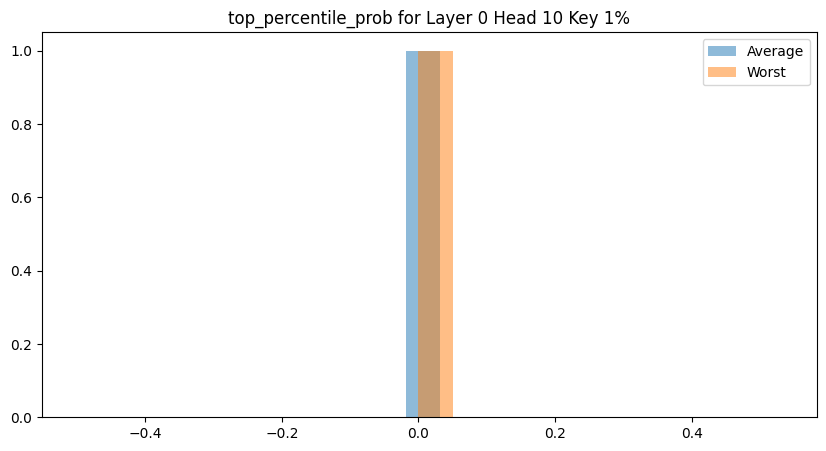

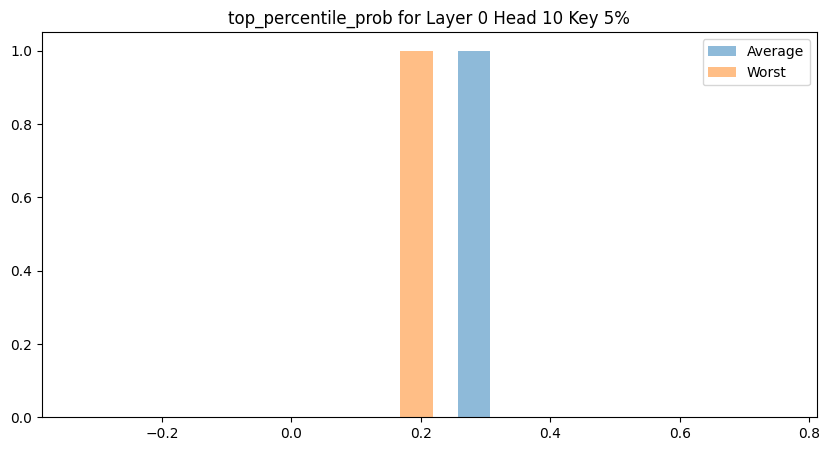

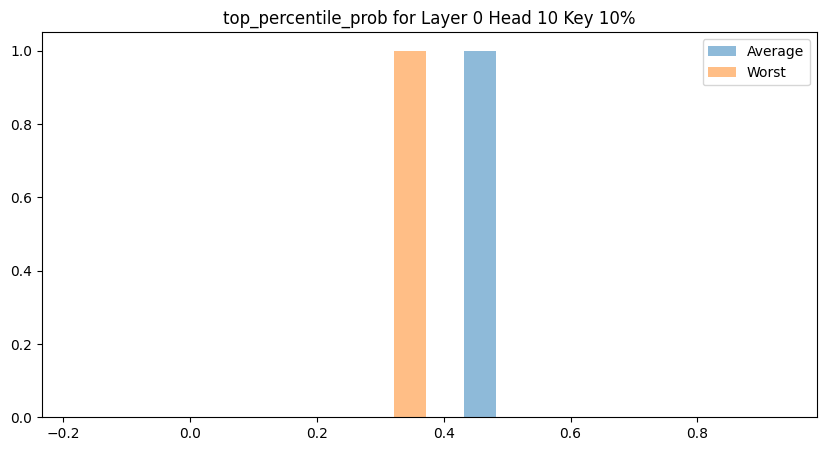

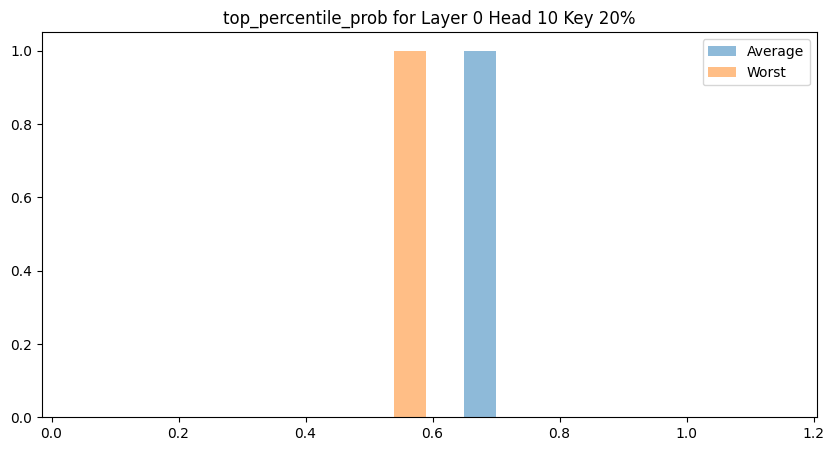

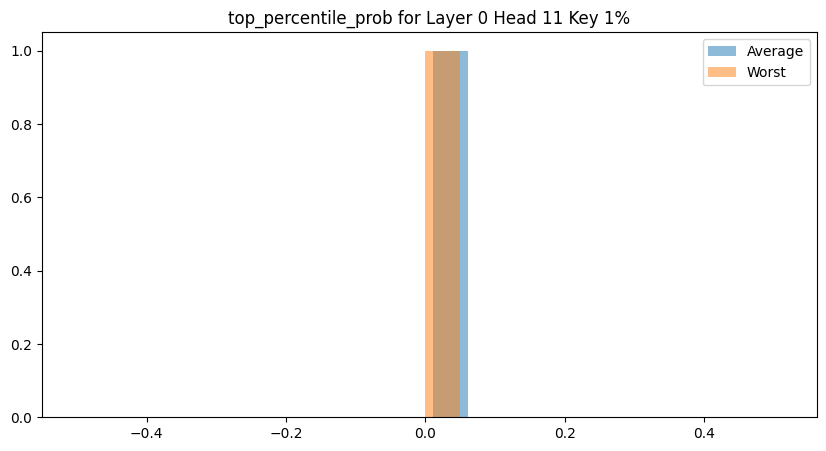

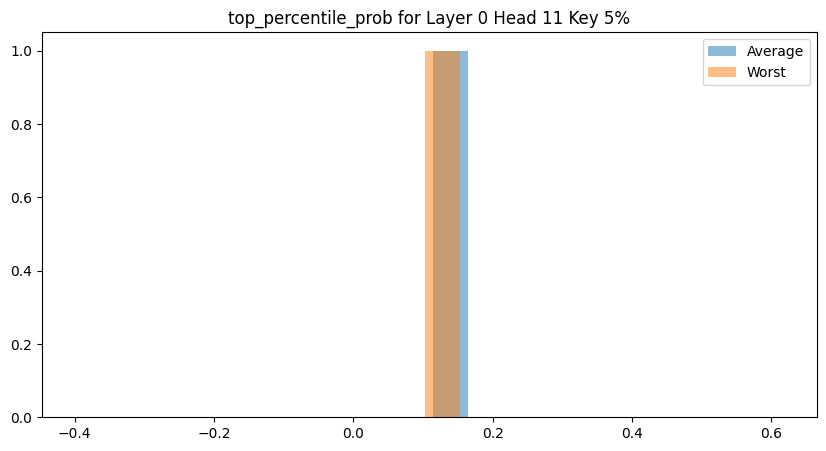

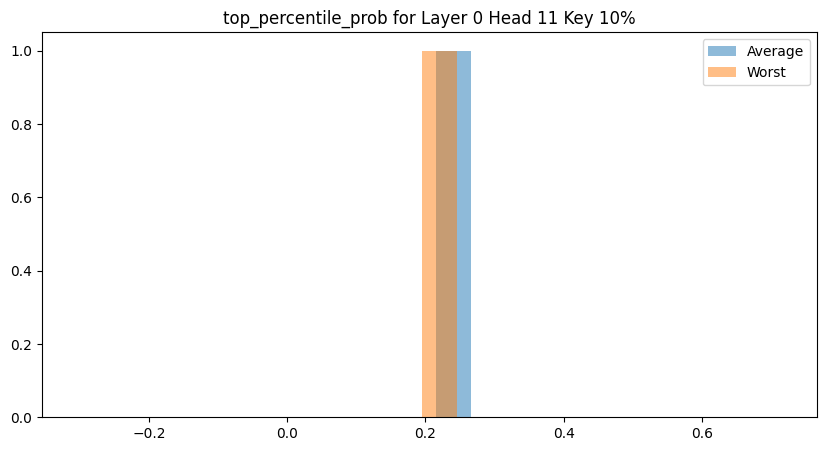

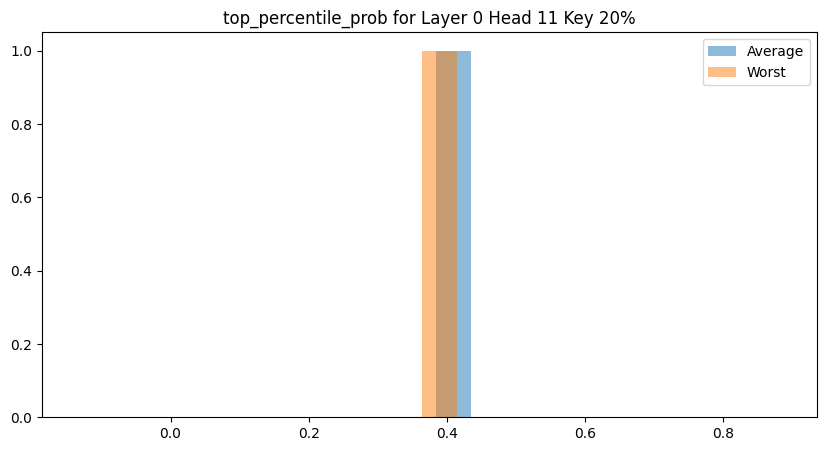

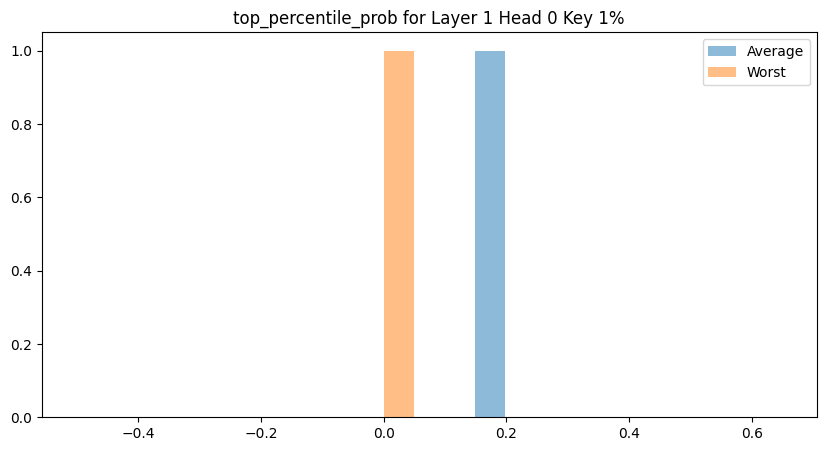

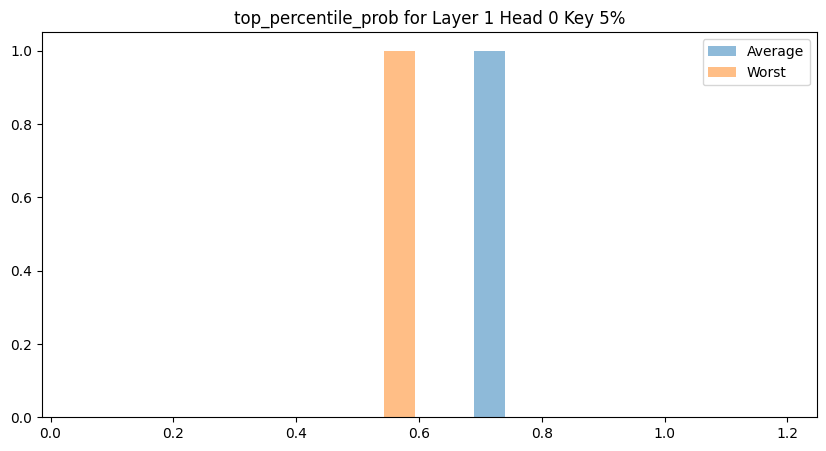

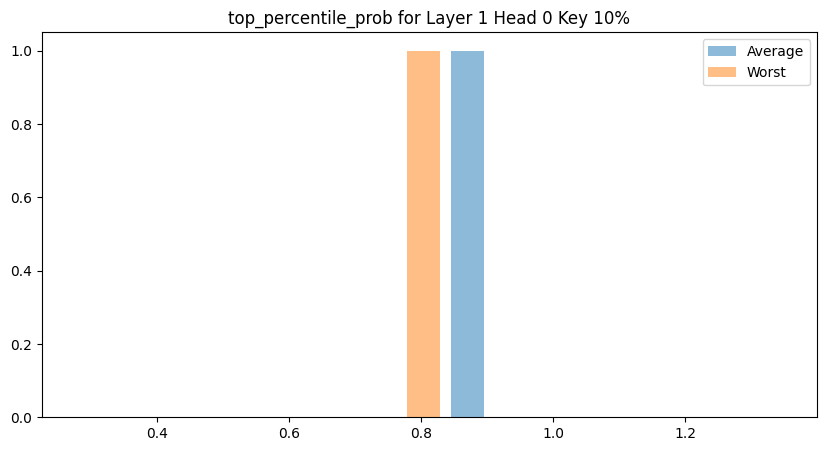

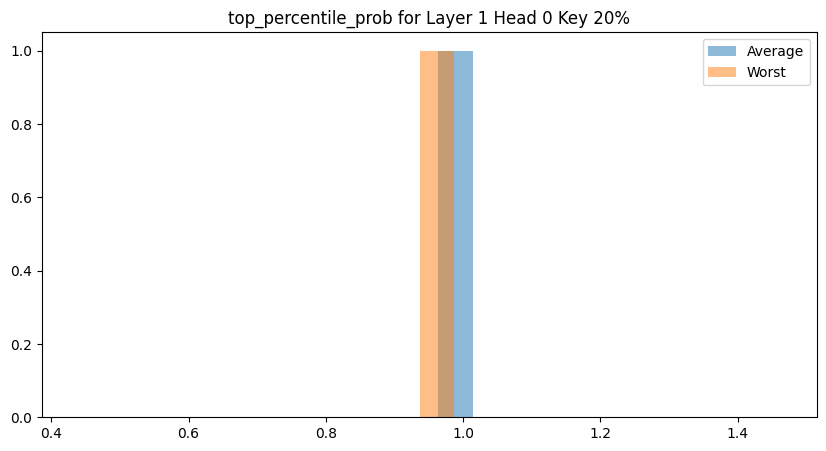

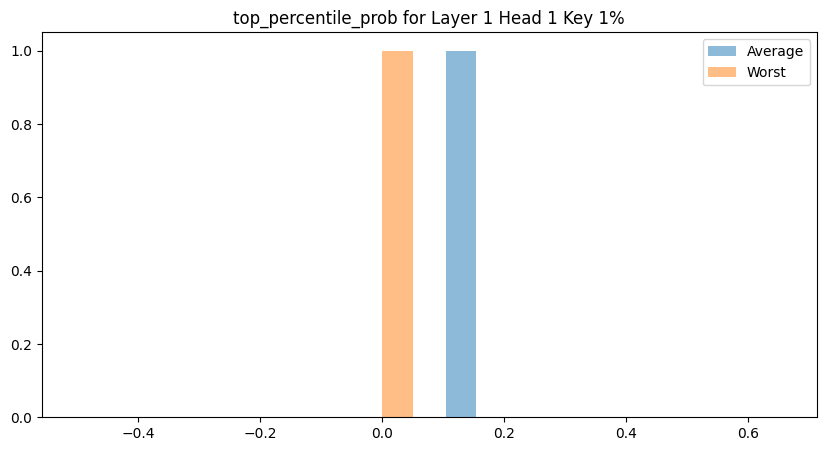

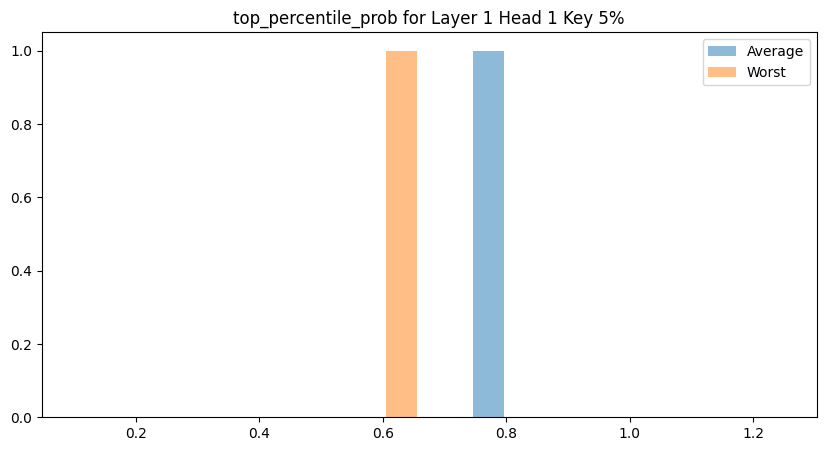

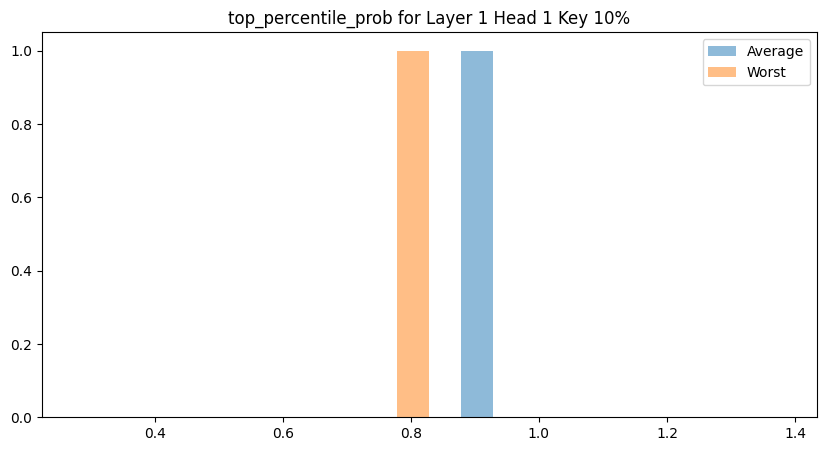

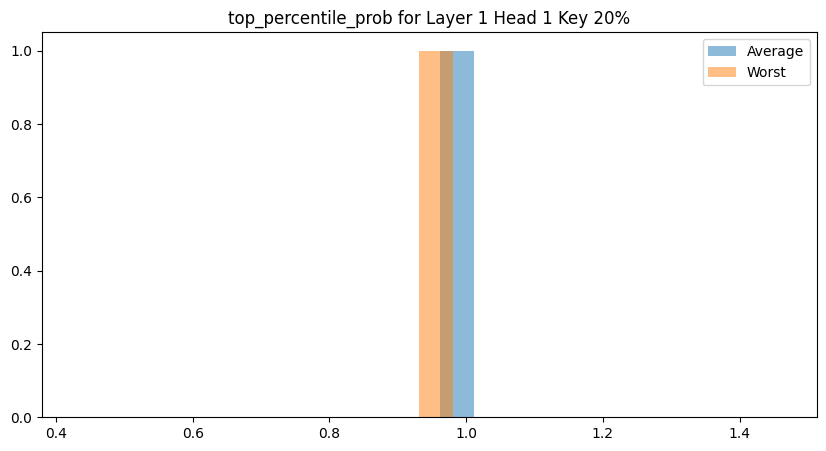

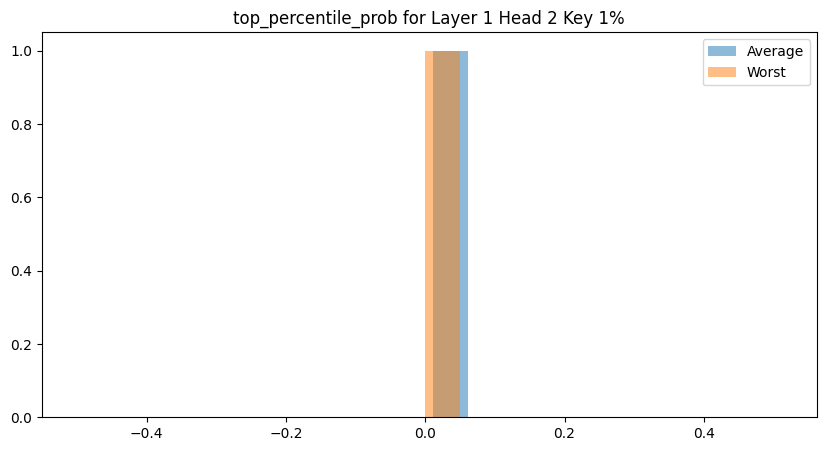

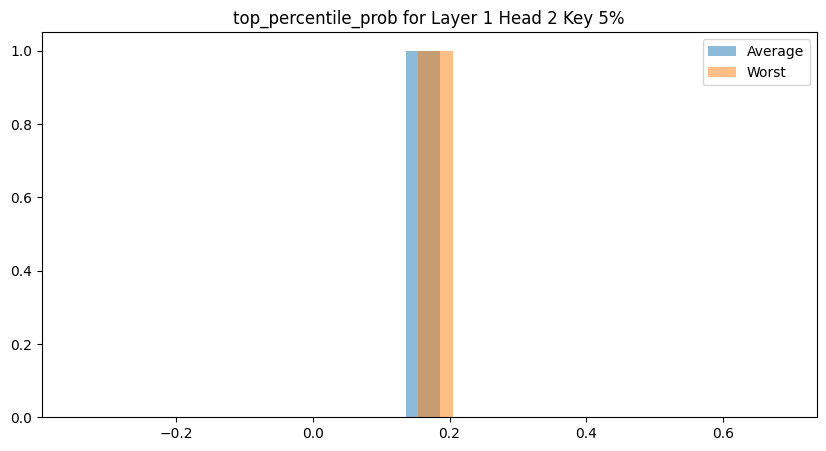

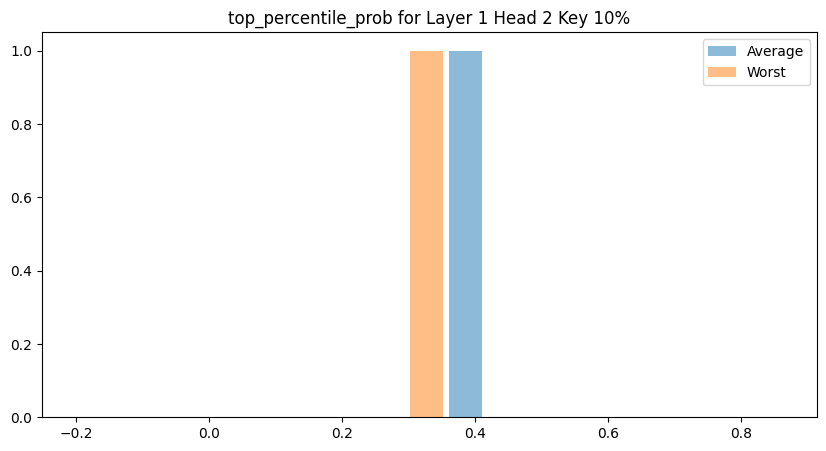

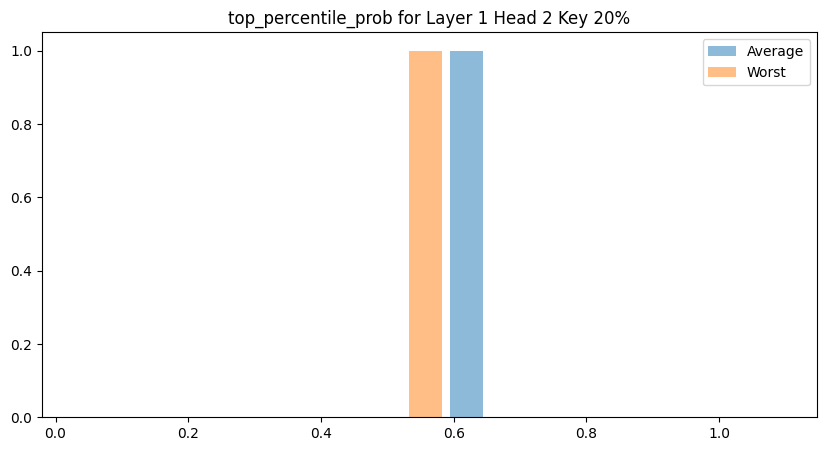

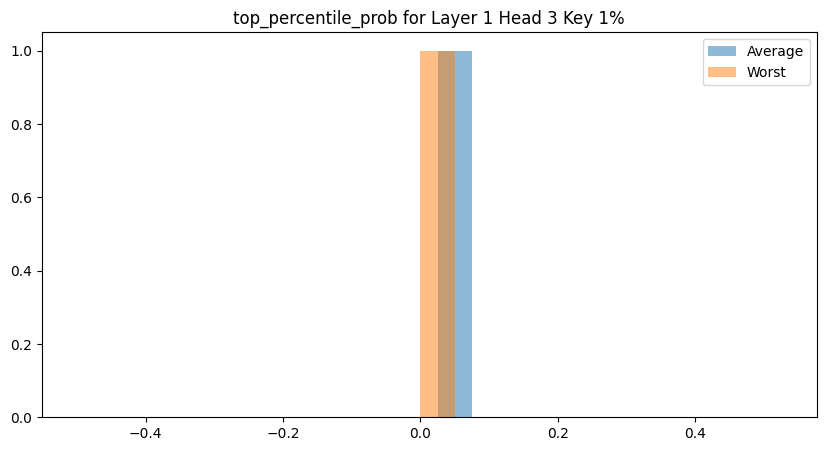

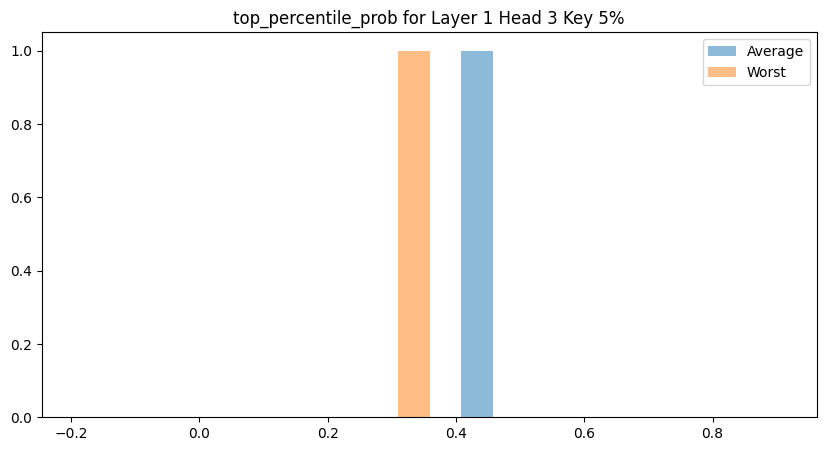

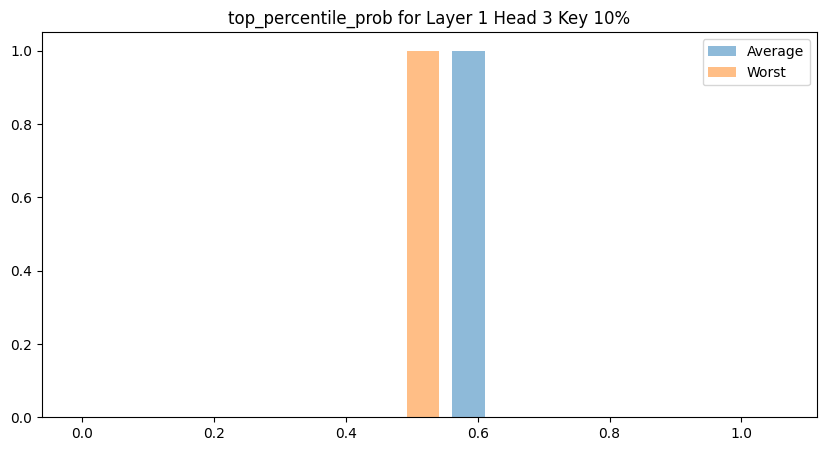

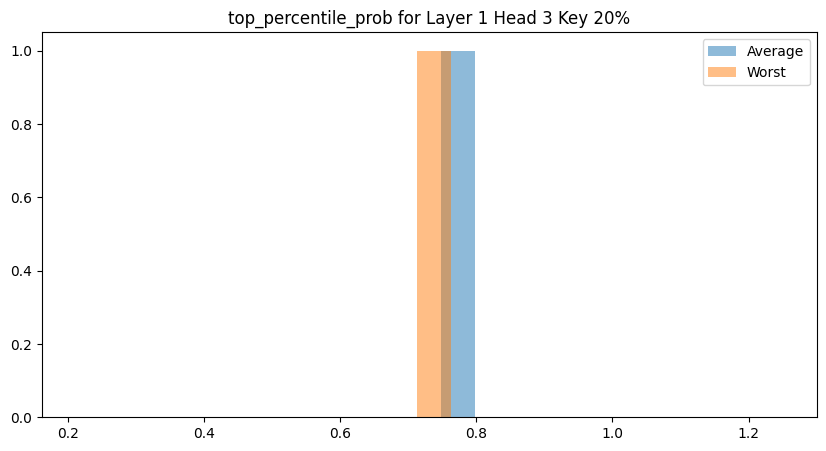

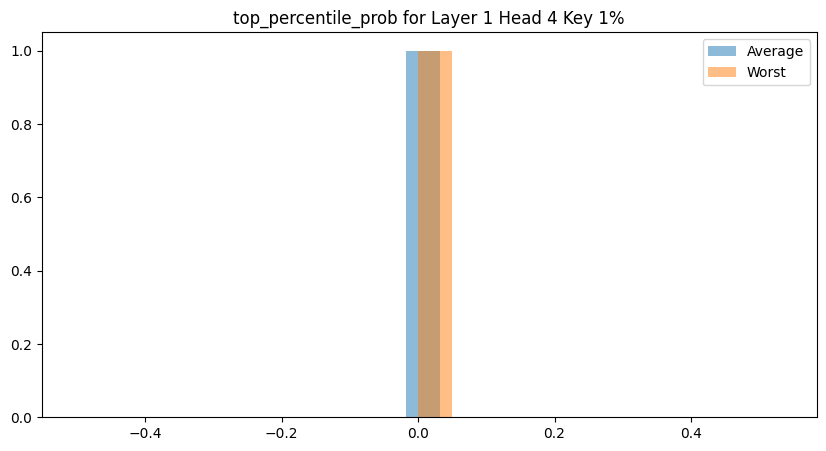

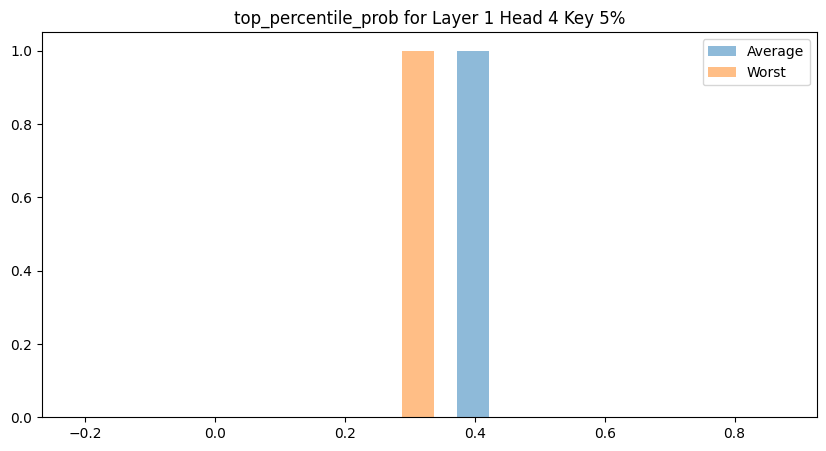

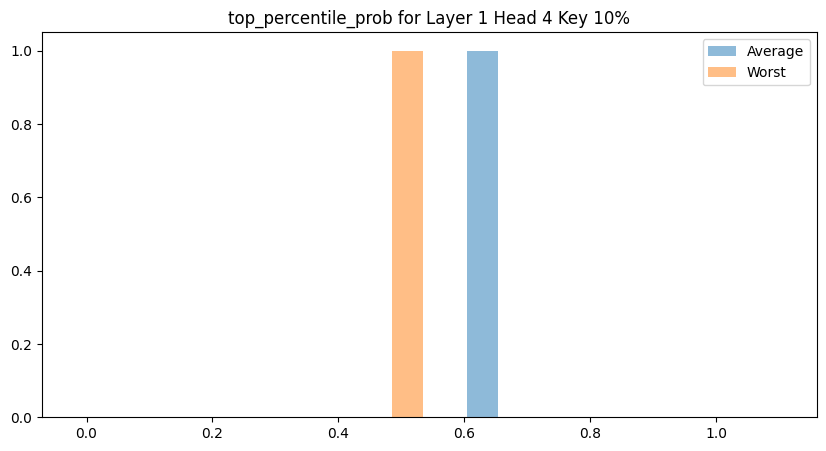

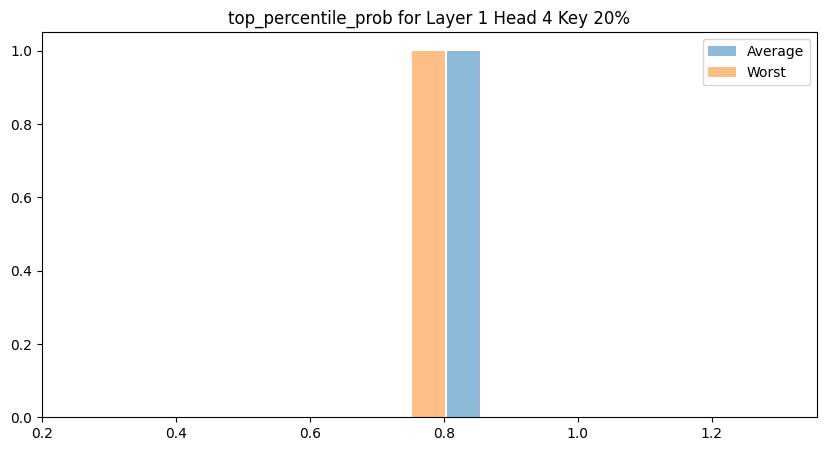

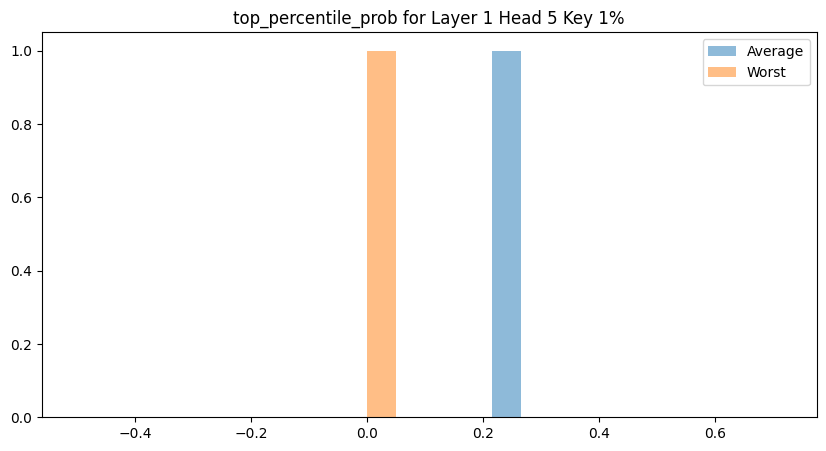

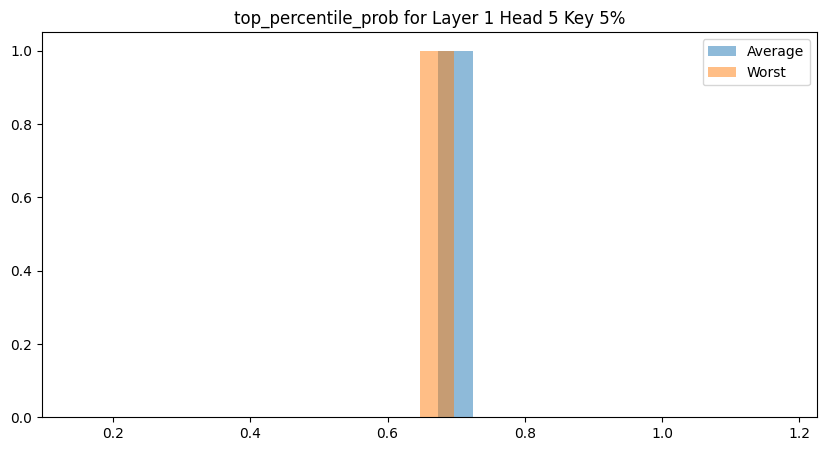

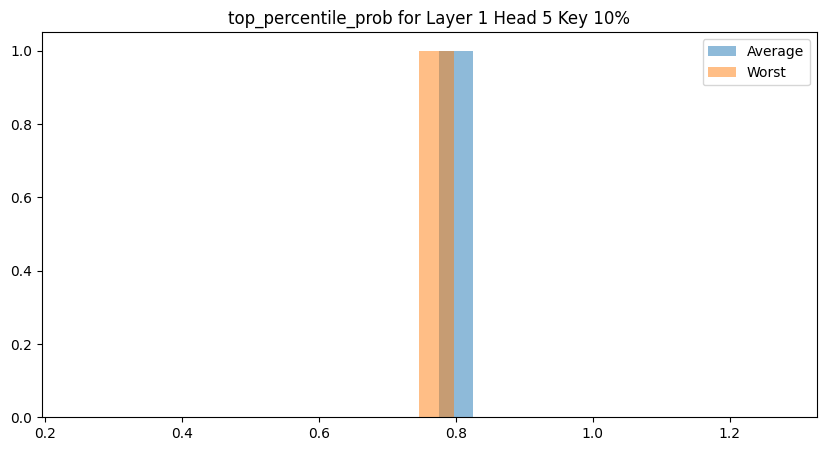

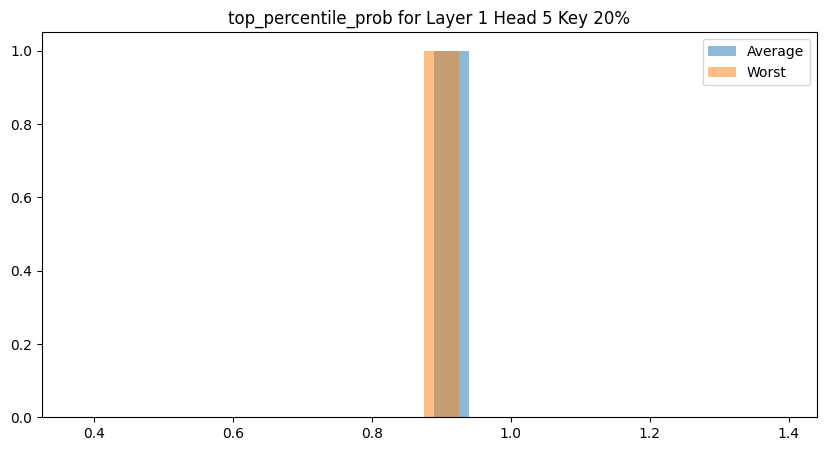

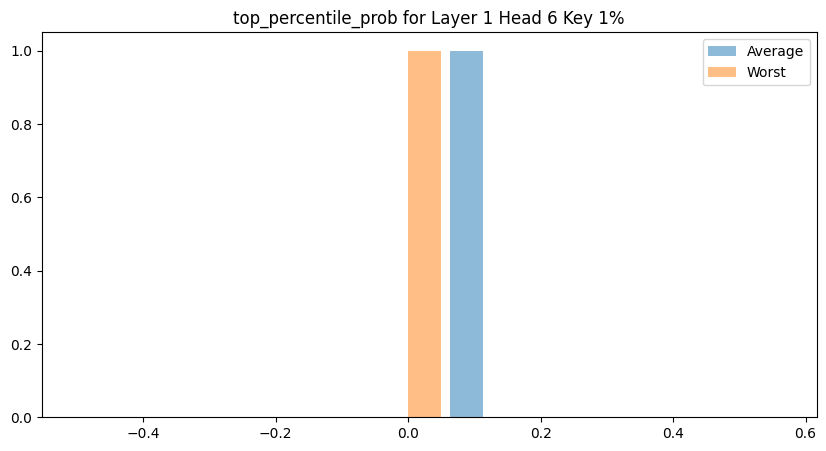

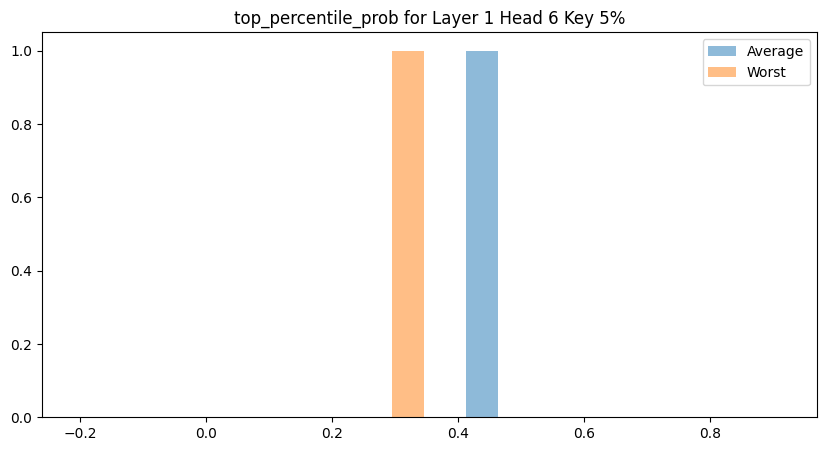

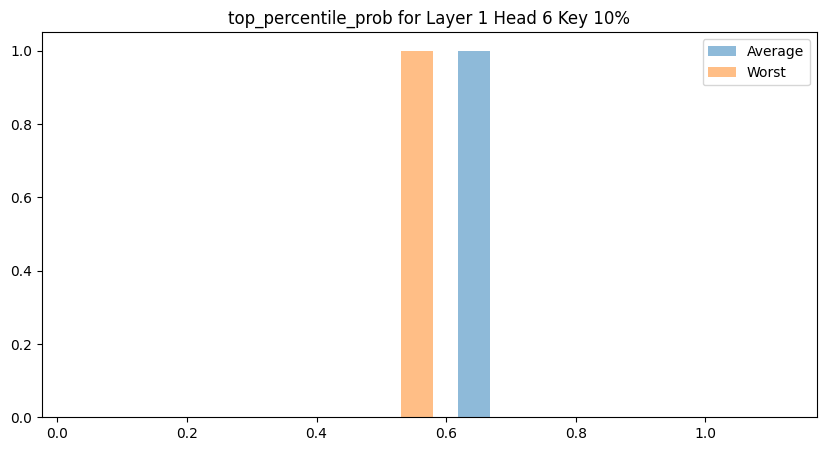

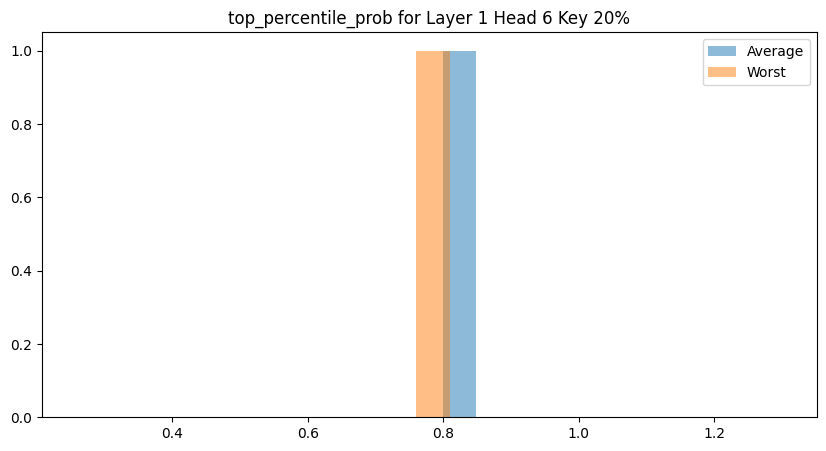

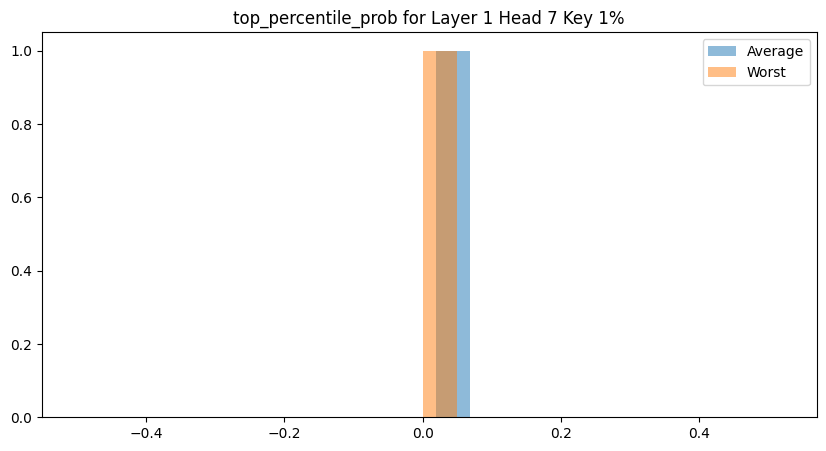

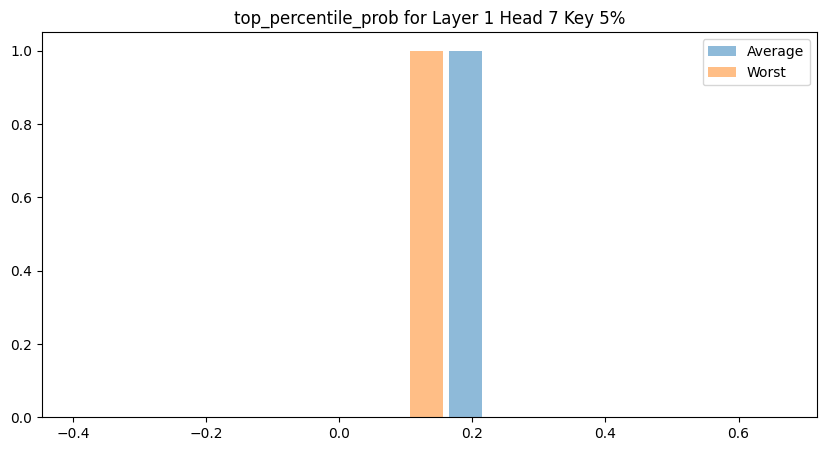

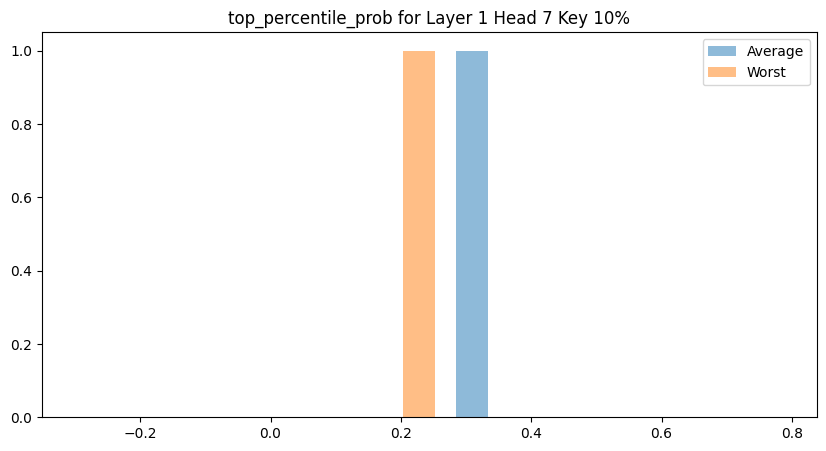

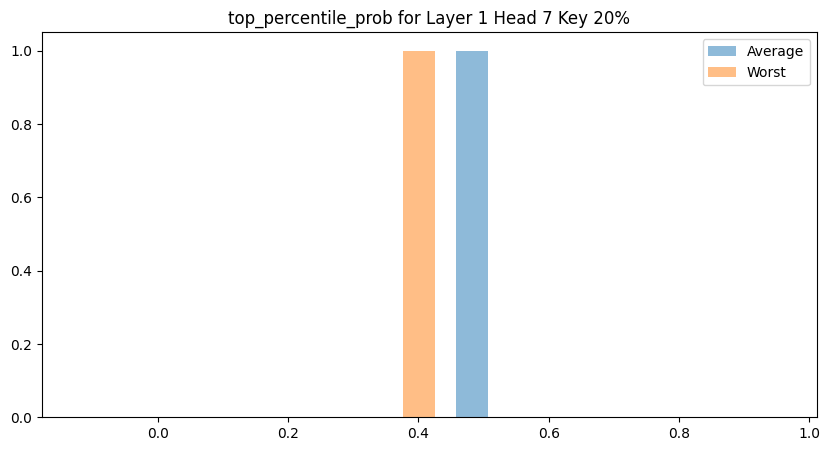

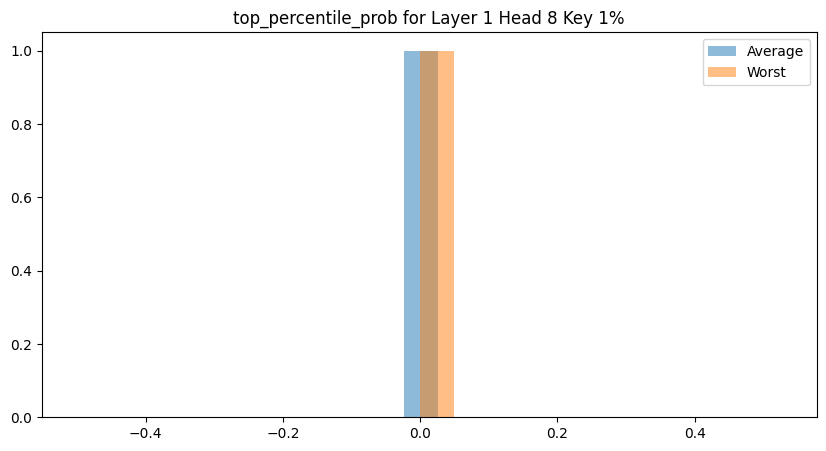

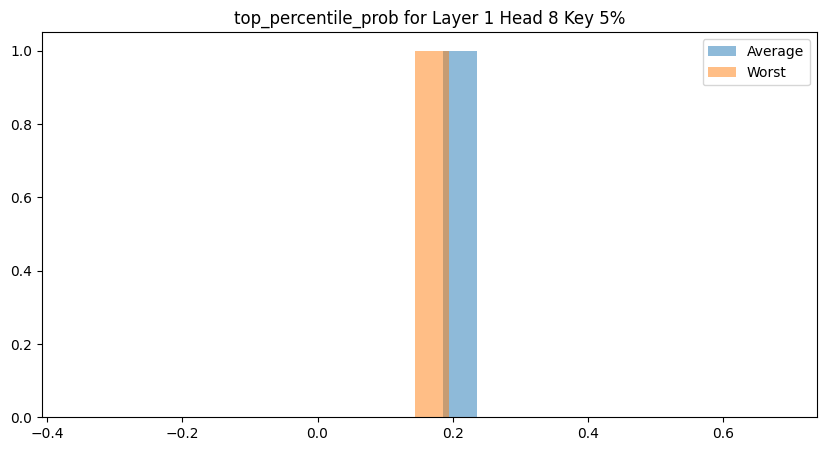

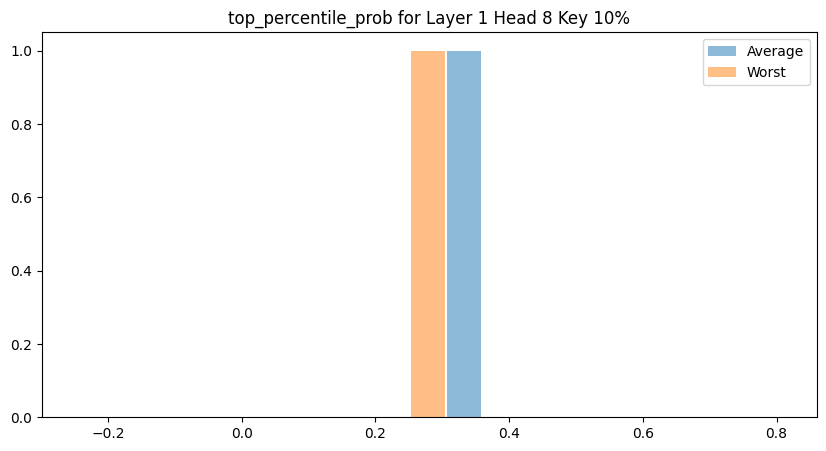

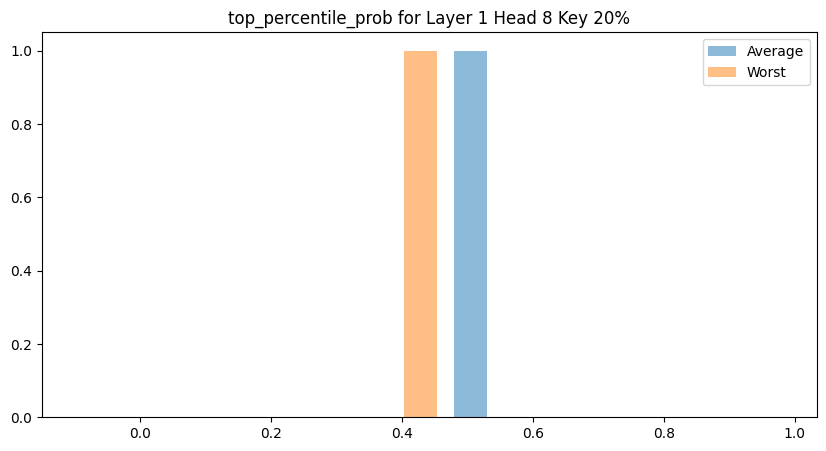

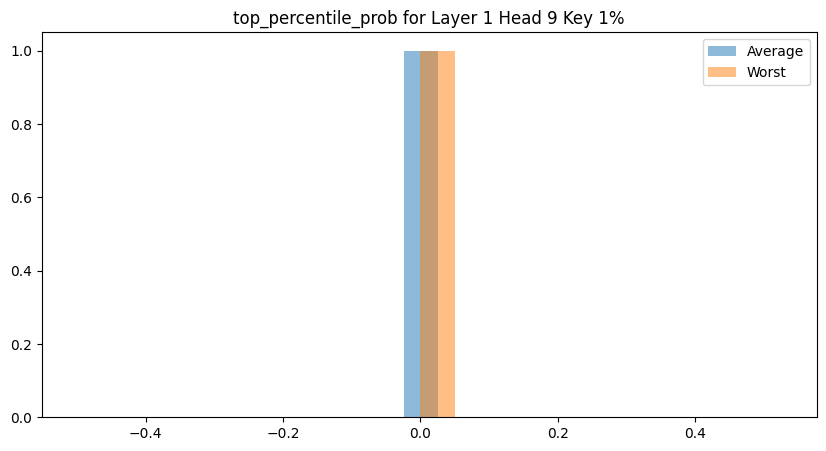

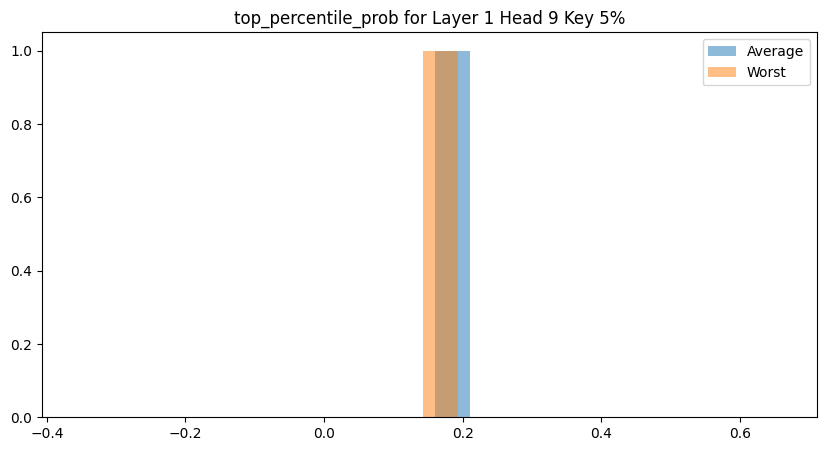

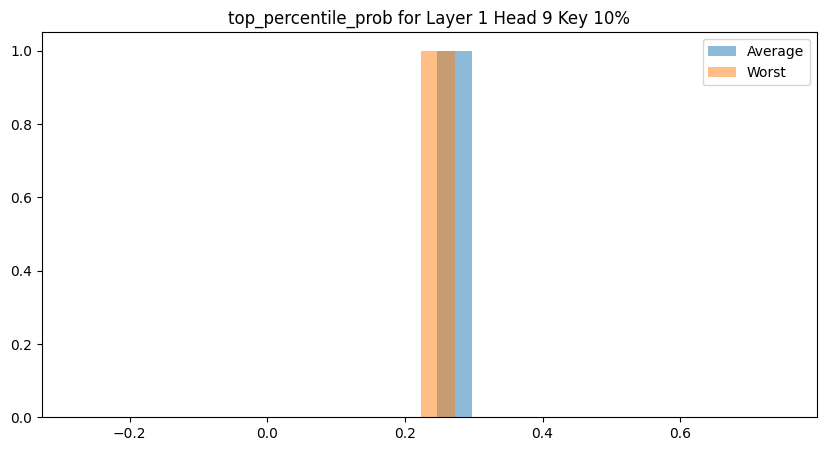

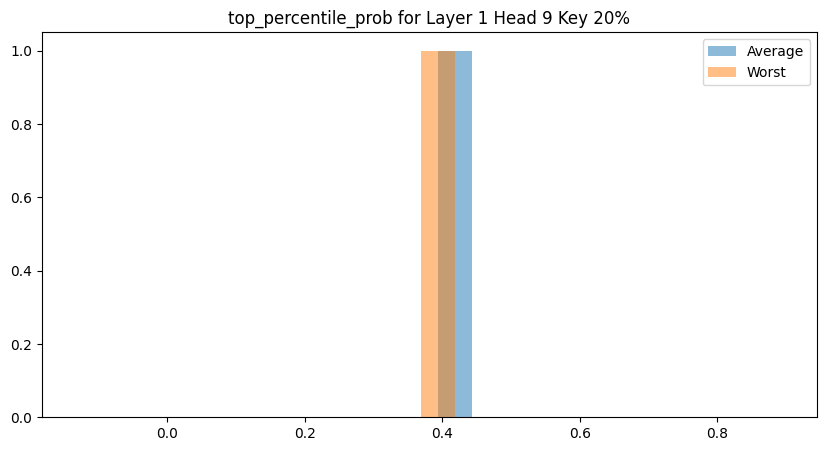

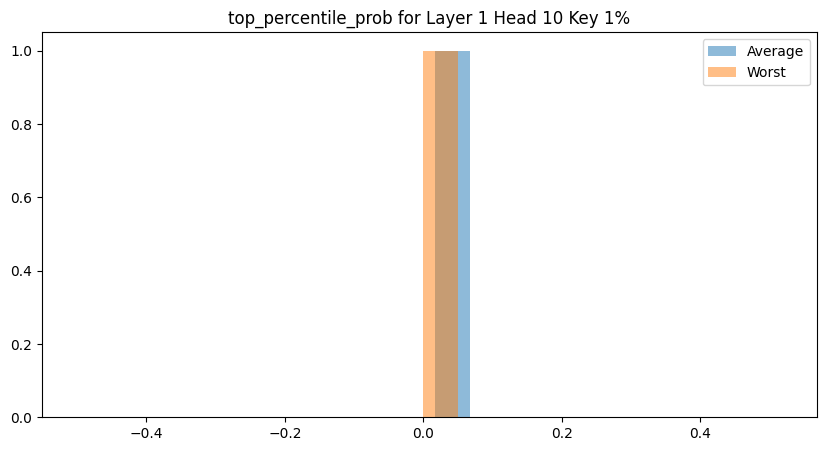

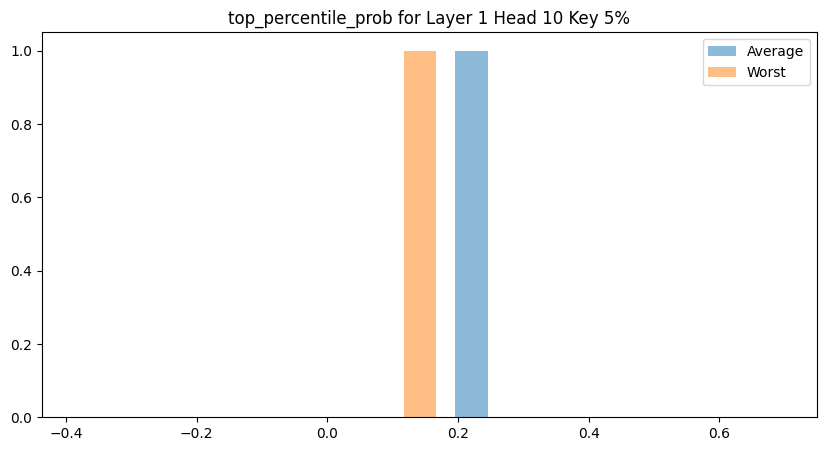

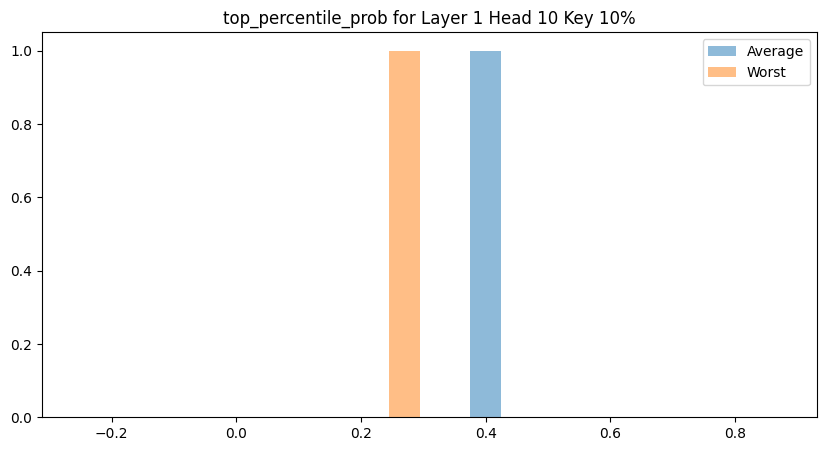

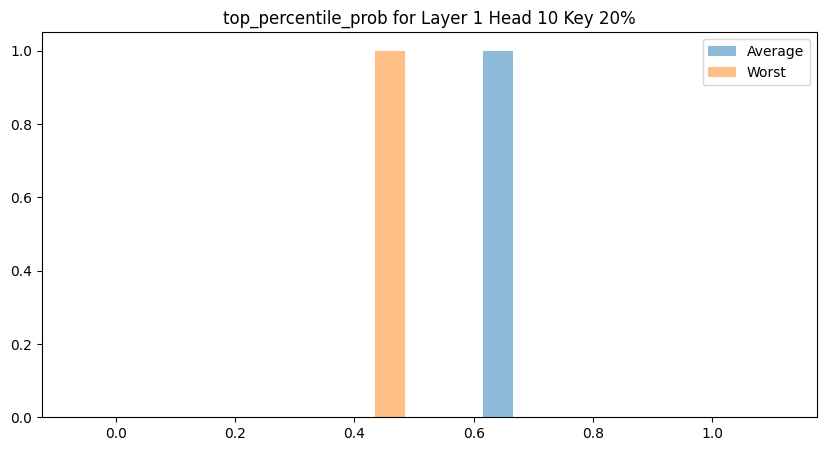

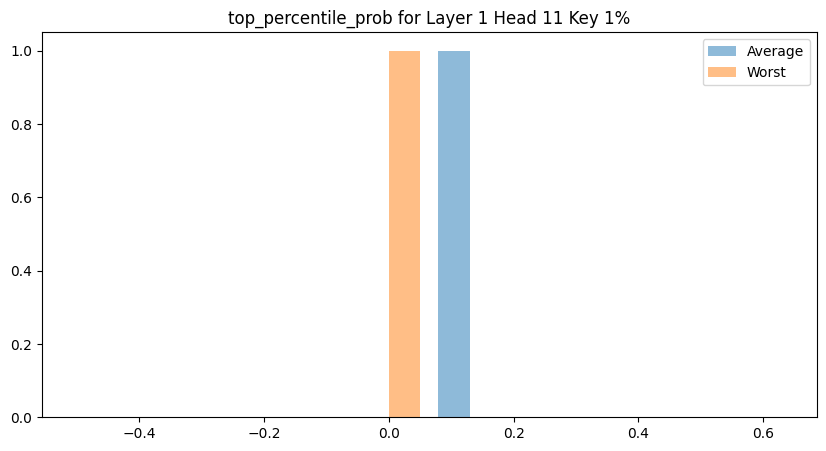

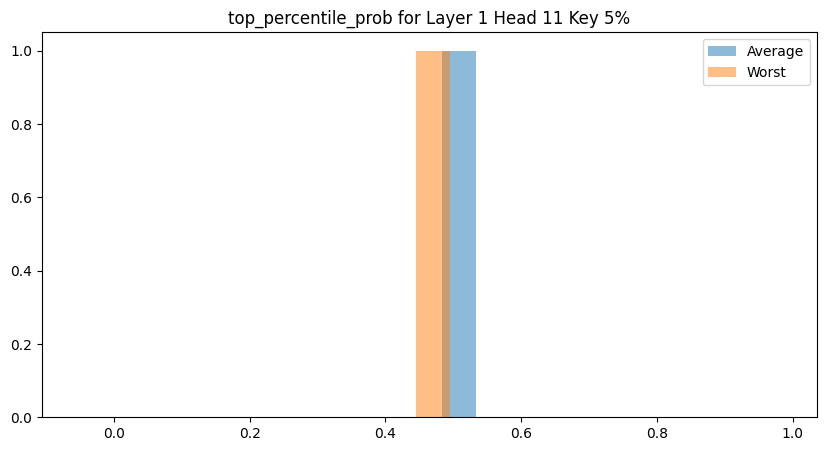

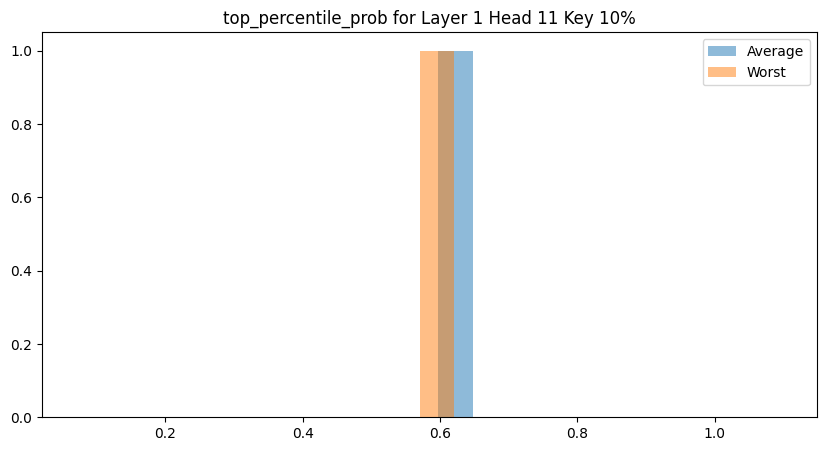

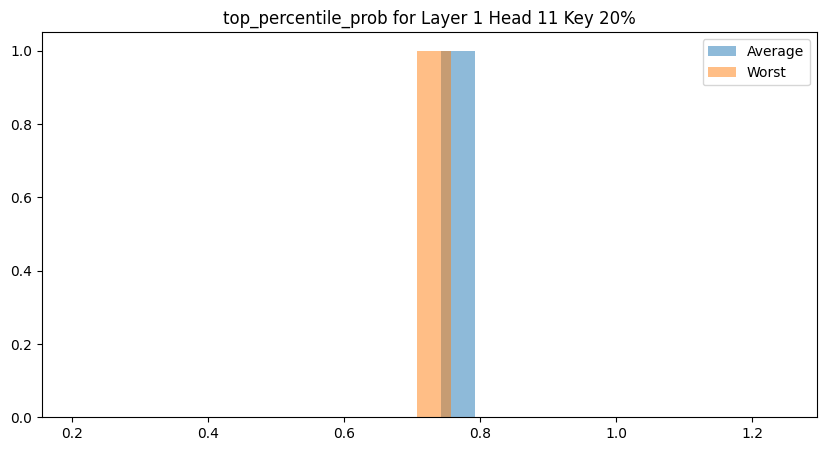

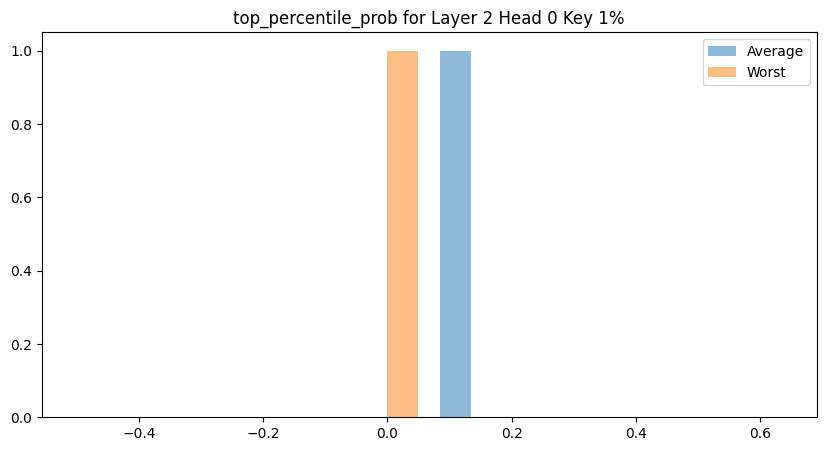

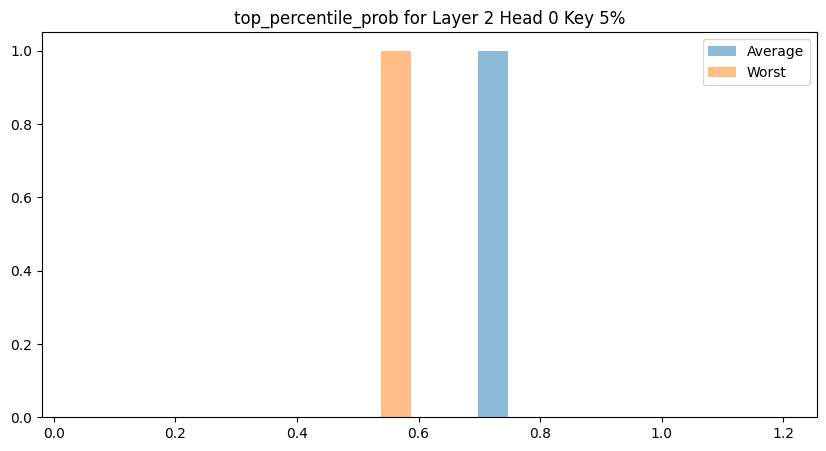

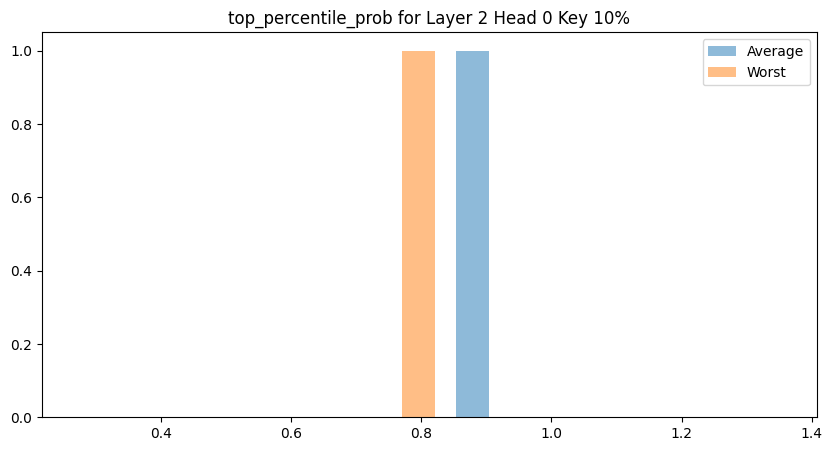

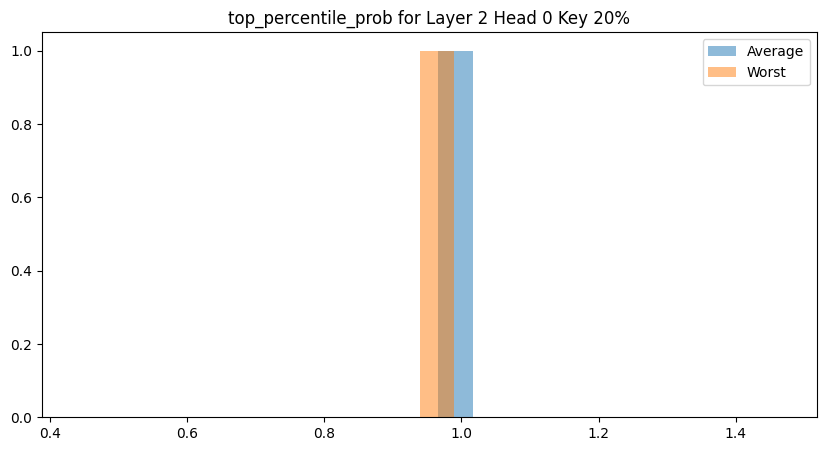

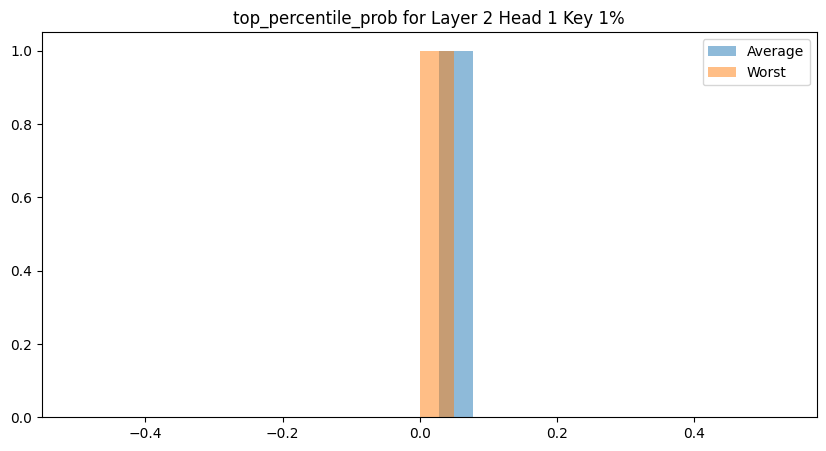

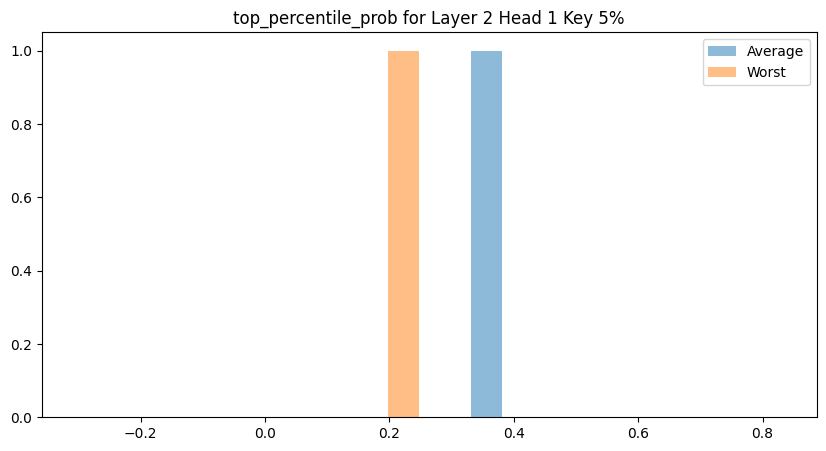

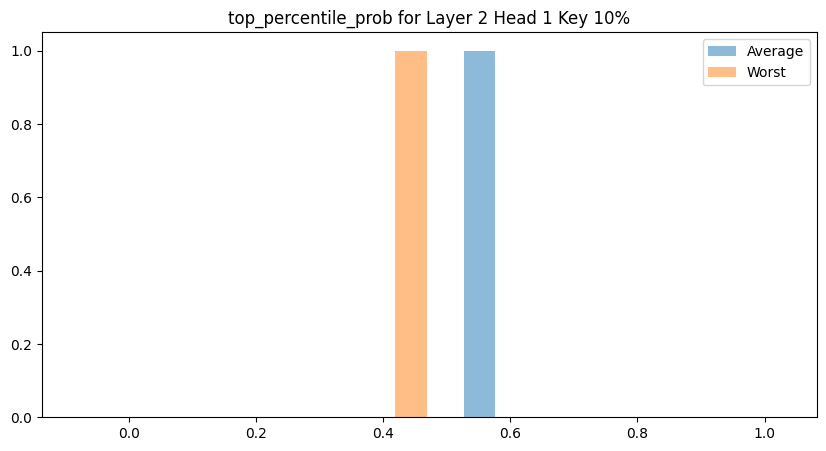

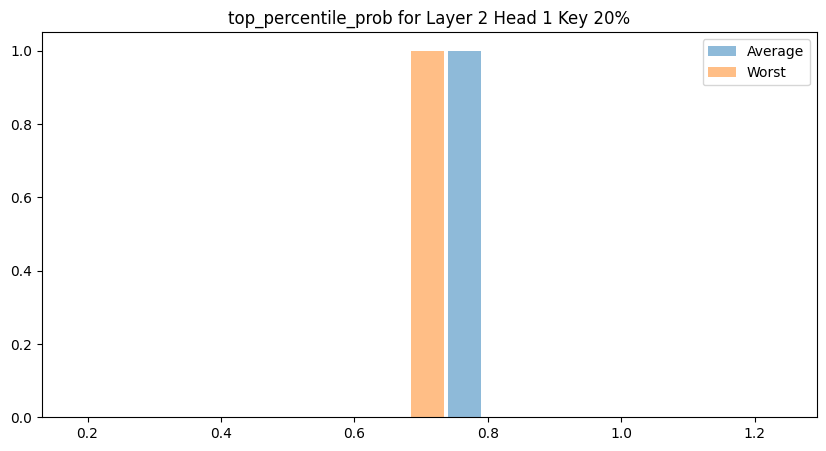

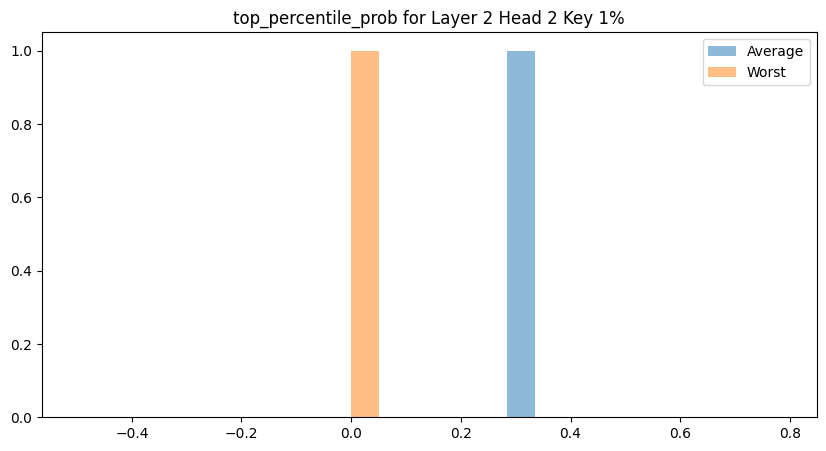

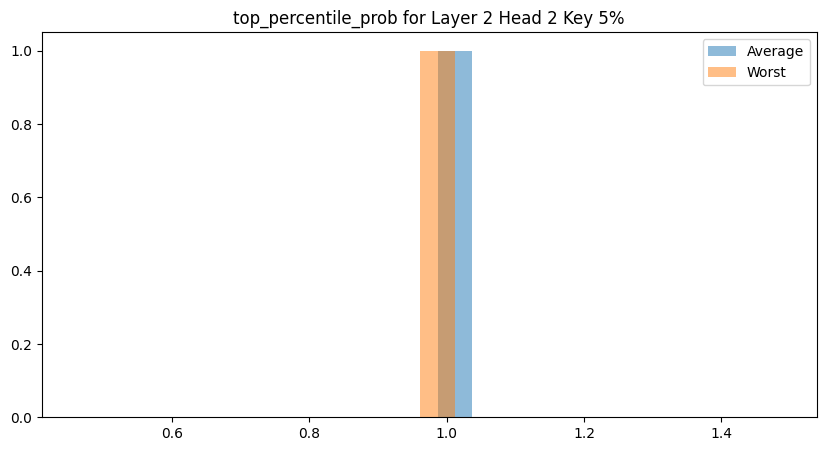

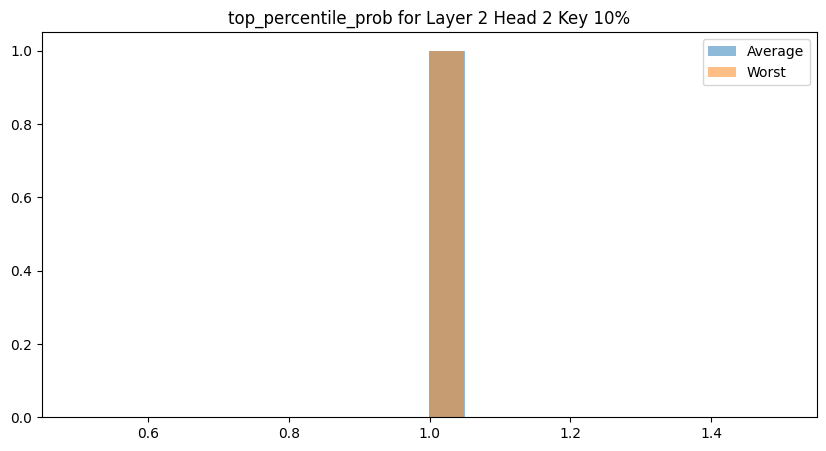

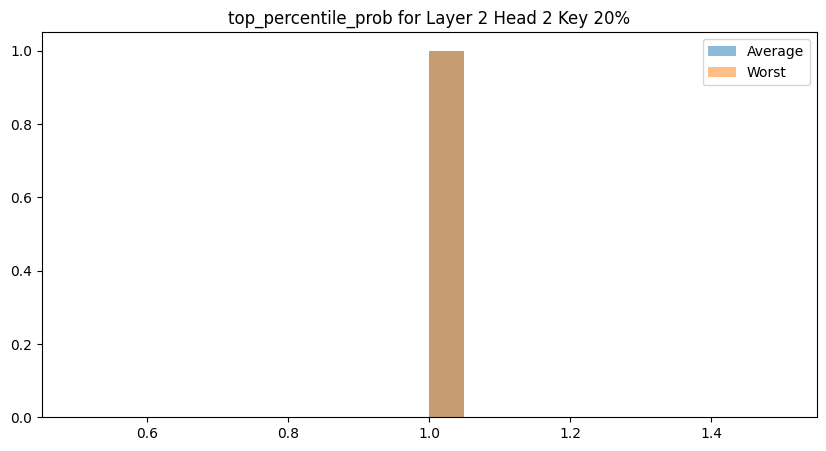

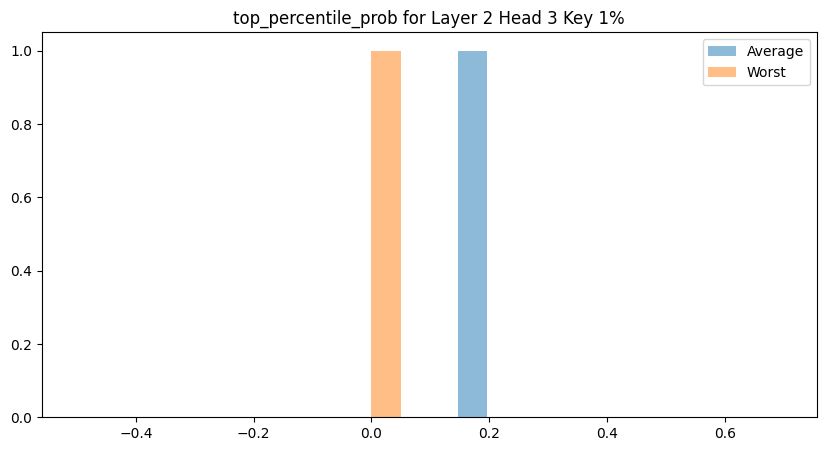

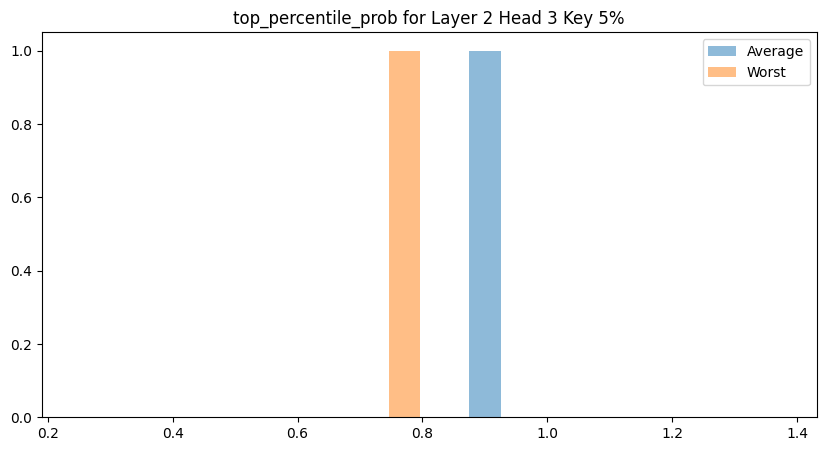

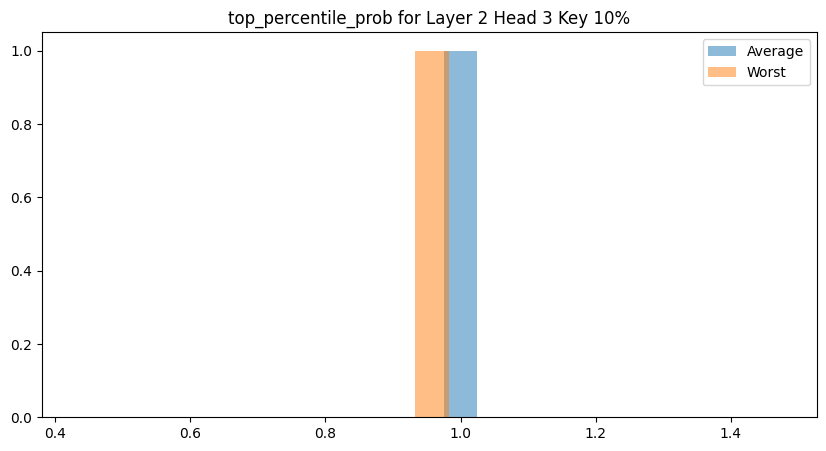

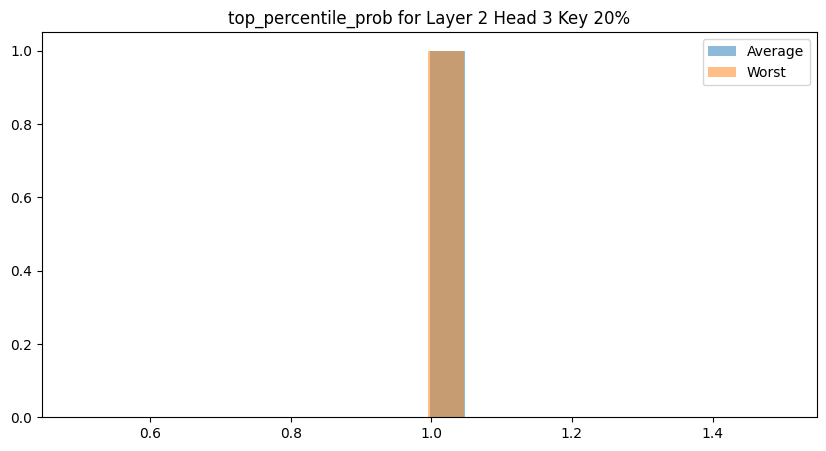

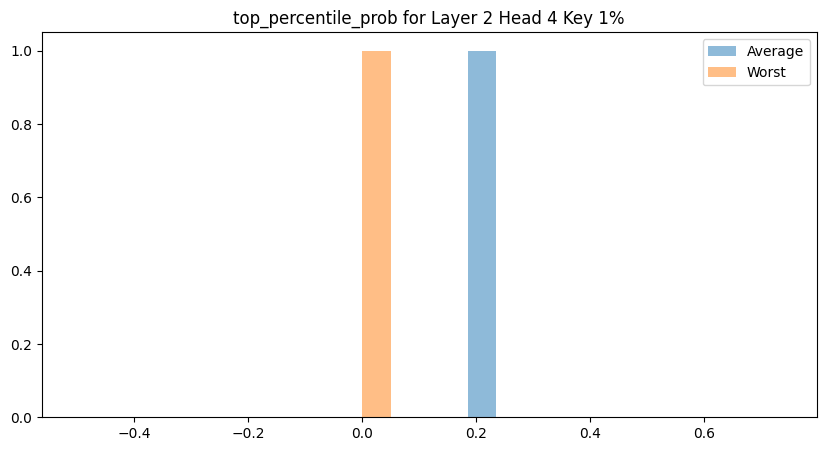

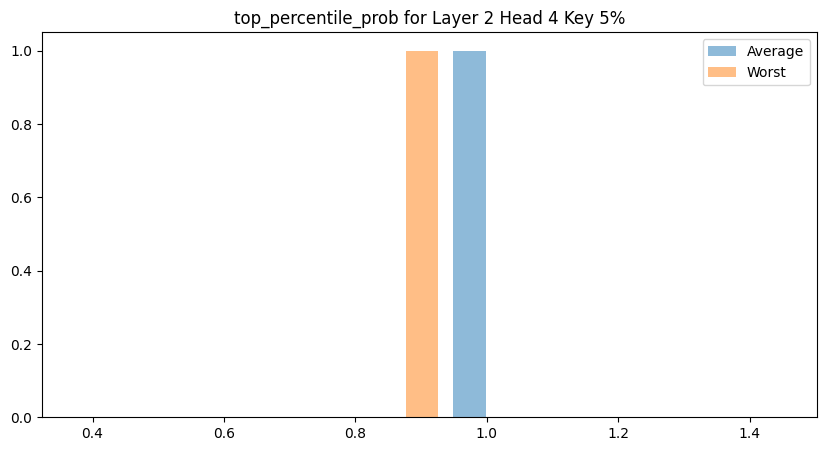

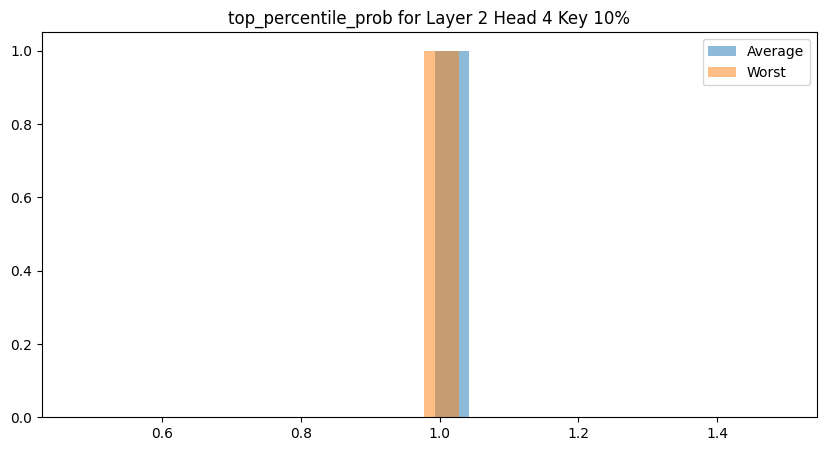

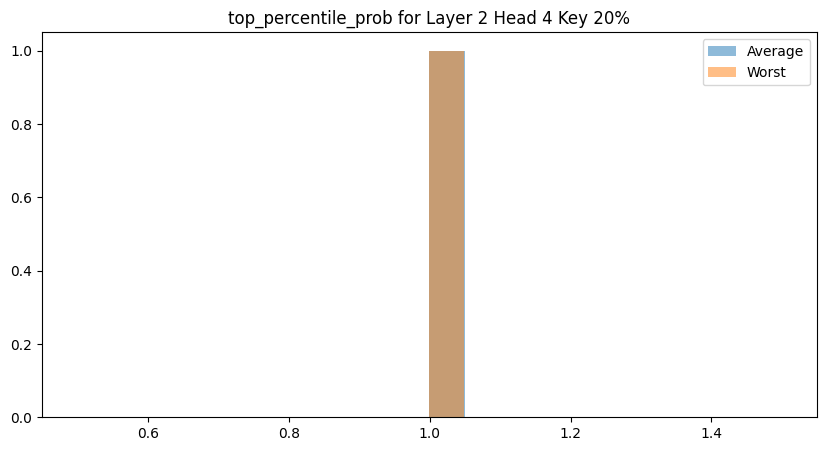

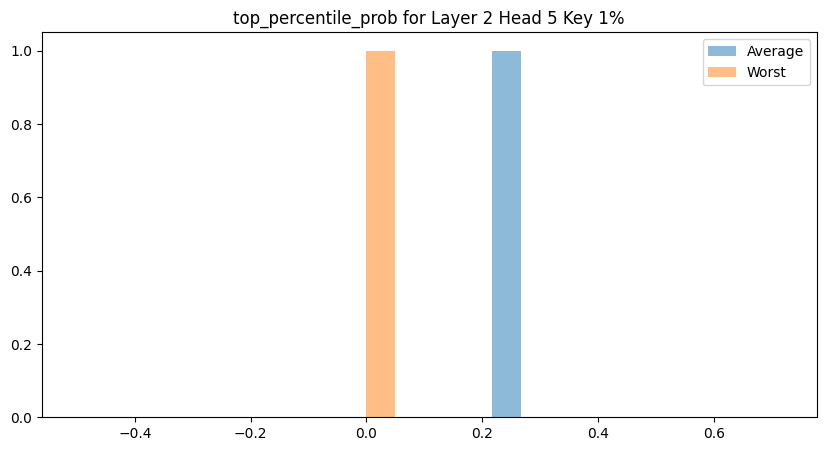

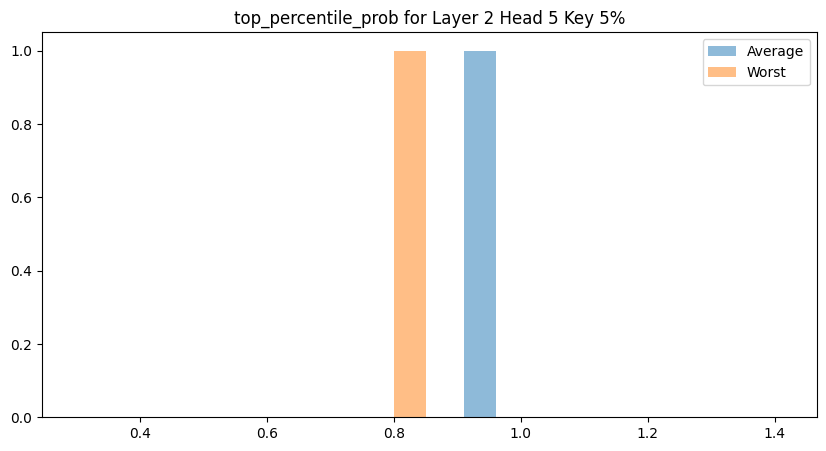

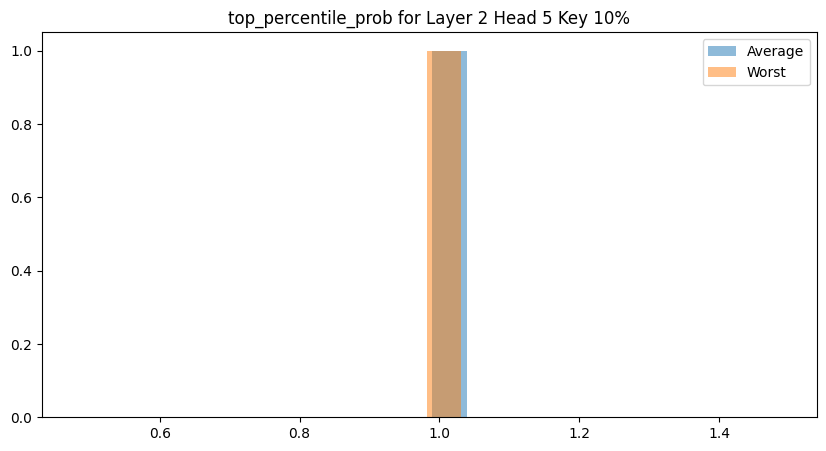

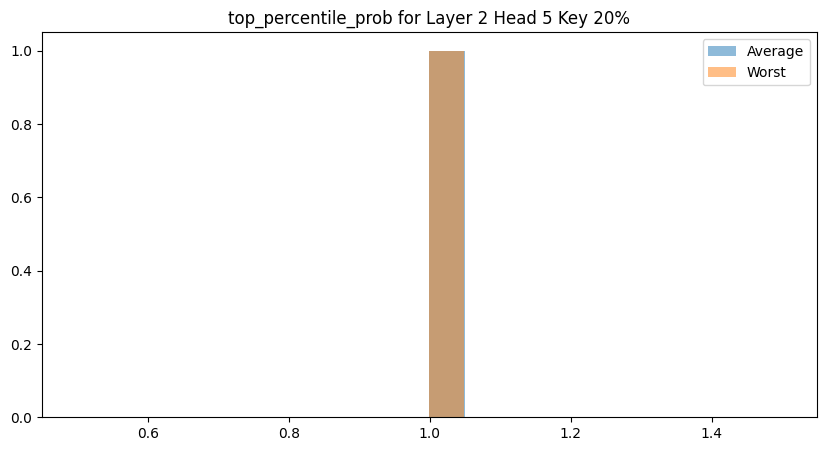

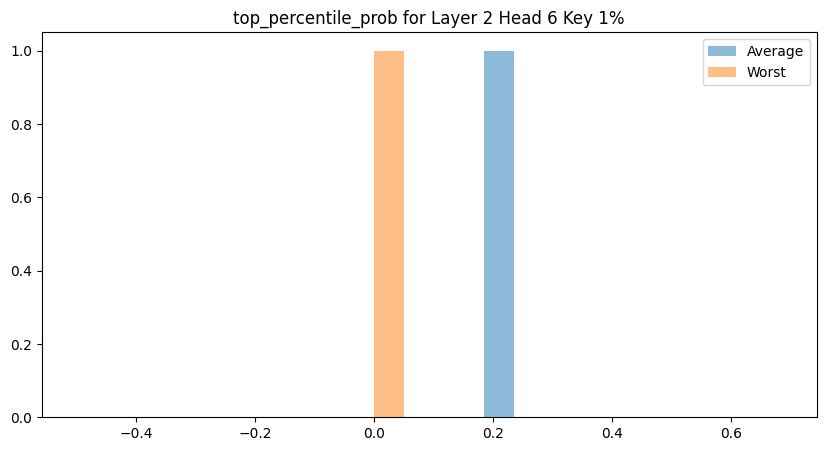

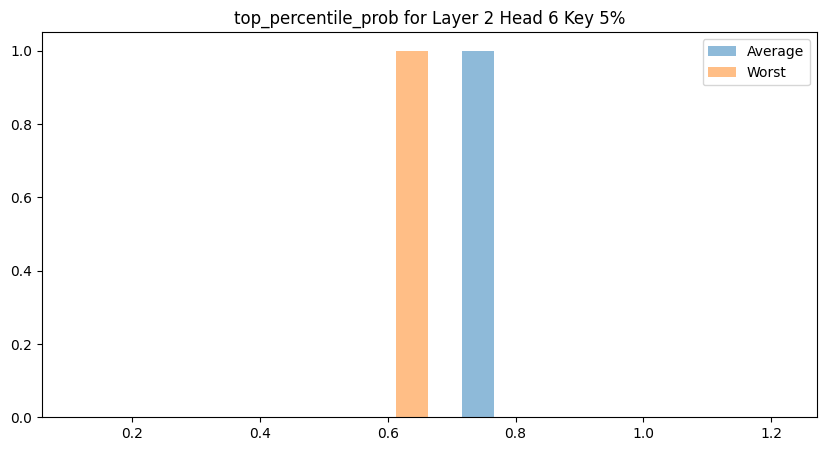

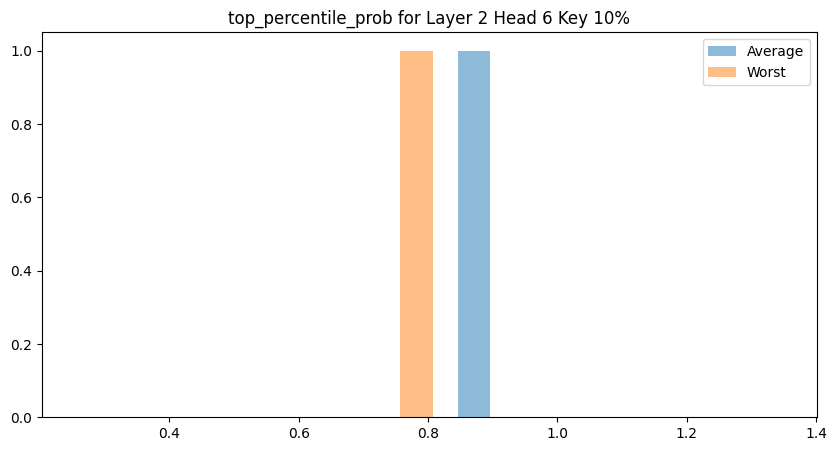

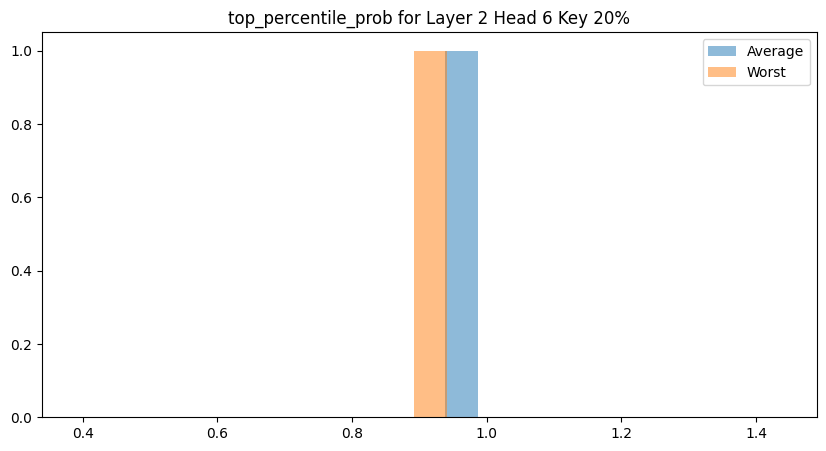

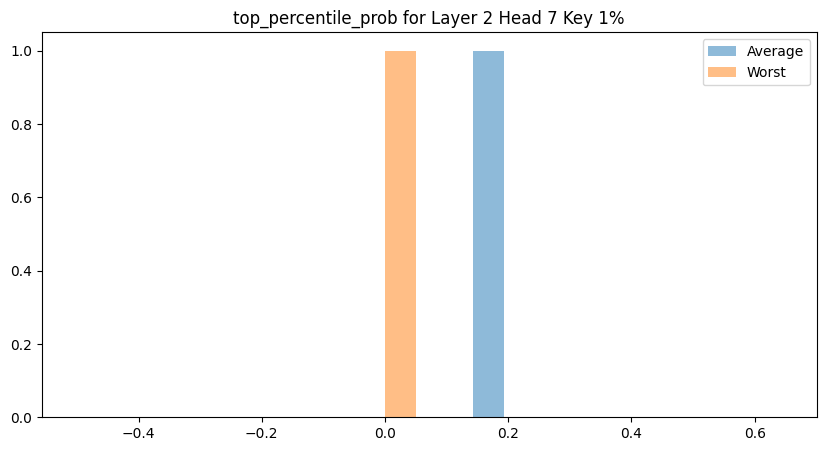

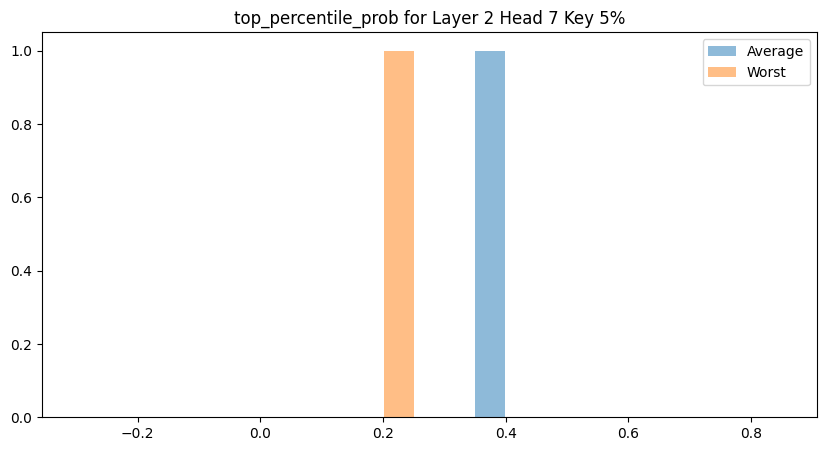

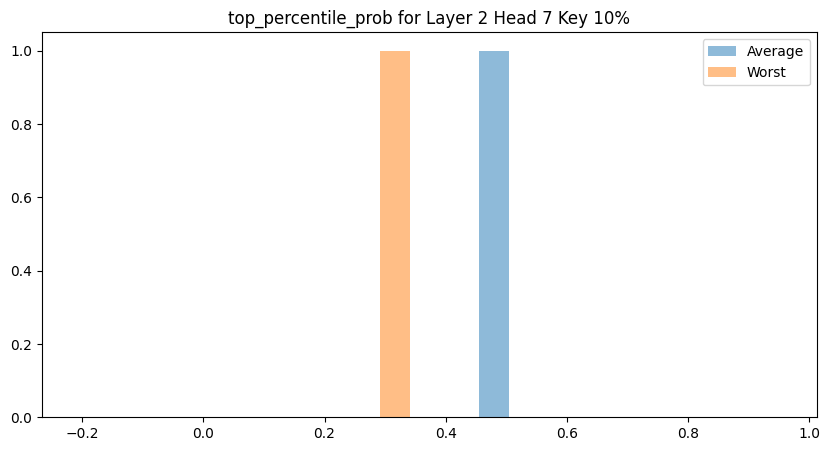

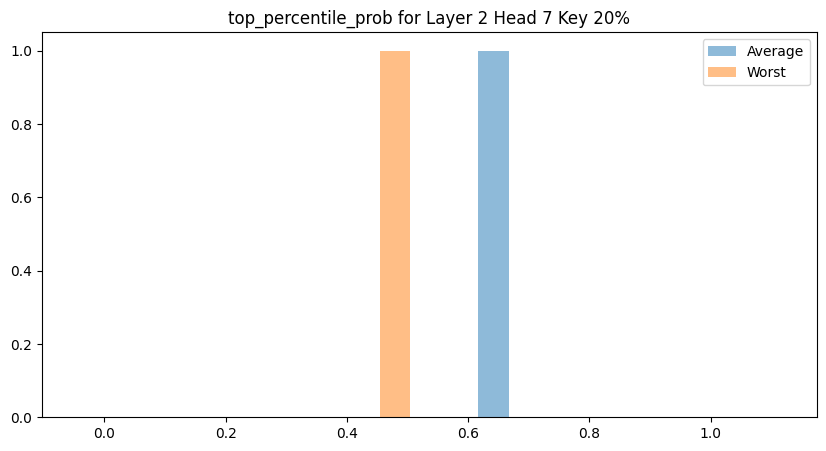

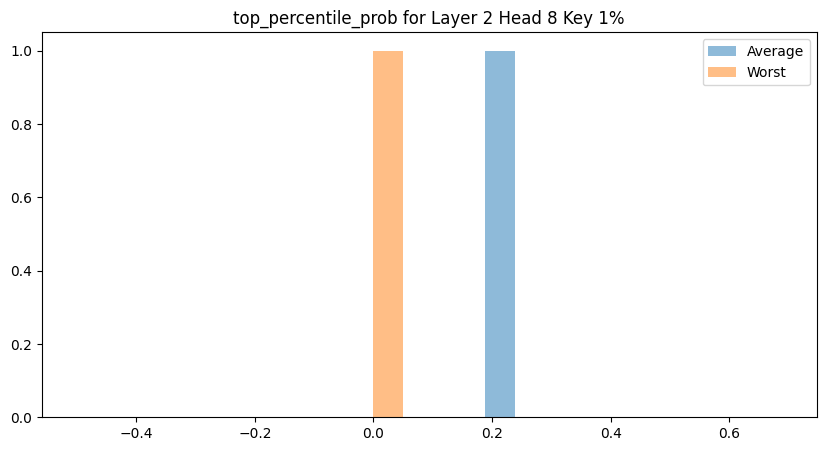

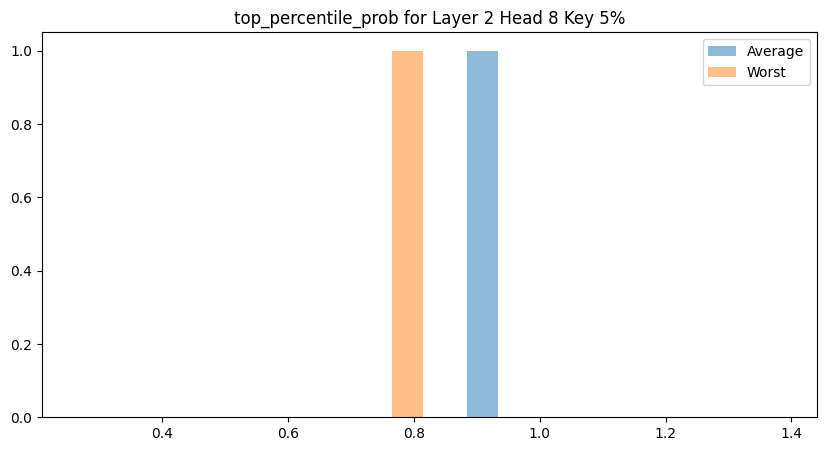

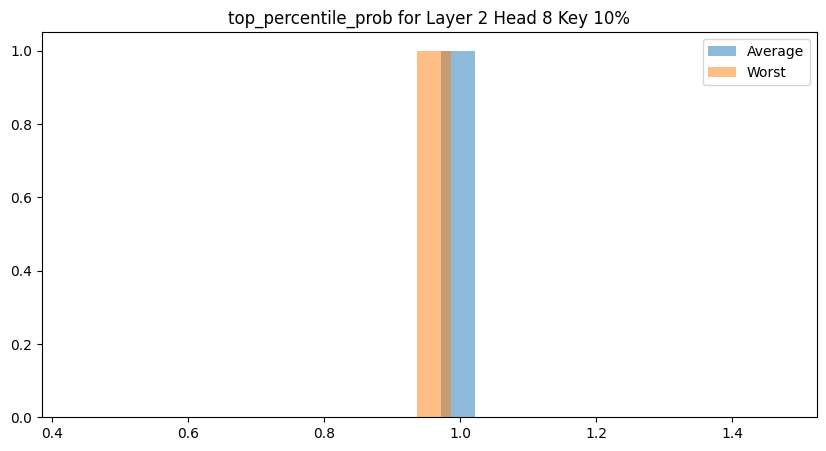

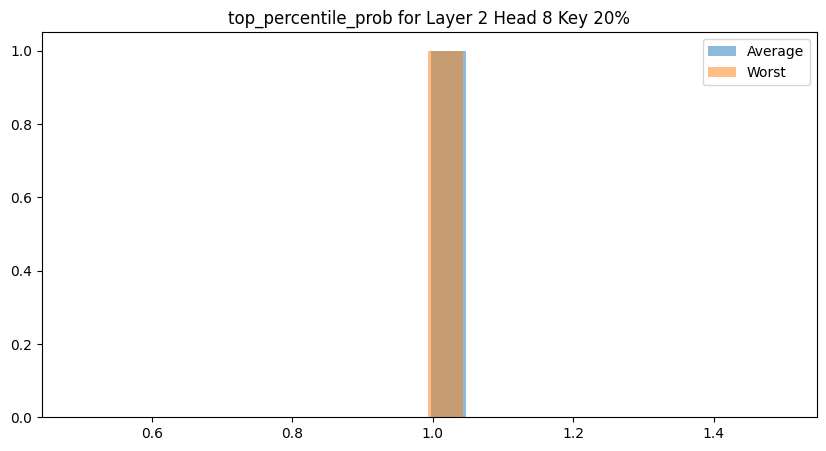

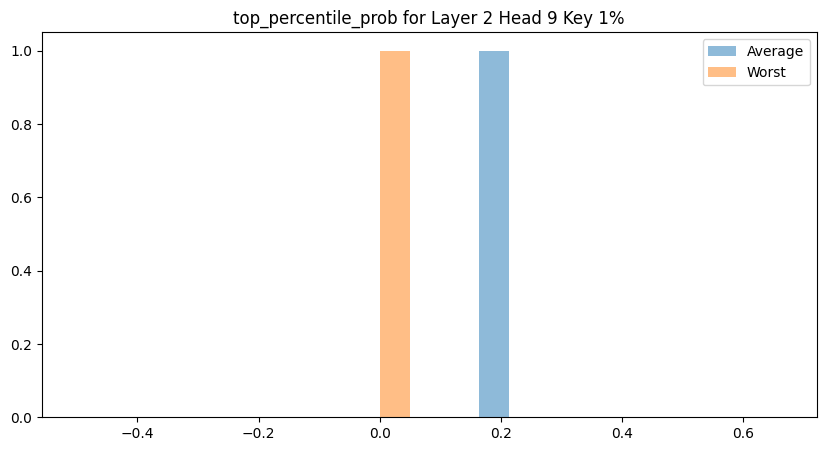

KeyboardInterrupt: 

In [206]:
plot_histograms_by_key(samples_metrics)